In [1]:
# Step 1: Install Required Libraries & Imports
# ==============================================================================
print("--- Step 1: Installing/Updating Libraries & Importing ---")
# Standard libs
import os, glob, random, time, io, gc, traceback, shutil, sys
import numpy as np, pandas as pd, cv2
import re # For text processing in remedy generation
import zipfile # For potential manual extraction if needed
import multiprocessing

# TensorFlow / Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress INFO logs
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Concatenate, Reshape, Multiply,
                                     BatchNormalization, Activation, GlobalAveragePooling2D, Flatten)
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import Policy, set_global_policy

# Keras Applications (for Audio)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Plotting / Audio / Other
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch
import librosa, soundfile as sf
from PIL import Image as PILImage

# Hugging Face Transformers (for Swin Video Model & optional GPT-2)
try:
    import torch # PyTorch is needed for transformers
    from transformers import SwinModel, AutoFeatureExtractor, pipeline, AutoTokenizer, logging as hf_logging, set_seed
    hf_logging.set_verbosity_error() # Suppress verbose logs
    HUGGINGFACE_AVAILABLE = True
except ImportError:
    print("ERROR: transformers or torch library not found. Install them: pip install transformers torch torchvision torchaudio")
    # Set flags and dummies if import fails
    HUGGINGFACE_AVAILABLE = False
    SwinModel = None; AutoFeatureExtractor = None; pipeline = None; AutoTokenizer = None; set_seed = lambda x: None
    torch = None # Make torch checkable

# Colab specific imports & checks
try:
    from google.colab import files, output
    from IPython.display import display, Javascript, Image as IPImage
    from base64 import b64decode
    IN_COLAB = True
    print("Colab environment detected.")
except ImportError:
    print("Warning: Not running in Google Colab. Live capture functionality disabled.")
    IN_COLAB = False
    # Define dummy functions/classes
    def display(*args, **kwargs): pass
    def Javascript(*args, **kwargs): pass
    def files(*args, **kwargs): return type('obj', (object,), {'upload': lambda: print("File upload only available in Colab.")})()
    def output(*args, **kwargs): return type('obj', (object,), {'eval_js': lambda x: None, 'register_callback': lambda x,y: None})()
    IPImage = lambda *args, **kwargs: None
    b64decode = lambda x: b""

print("Libraries imported.")


--- Step 1: Installing/Updating Libraries & Importing ---
Colab environment detected.
Libraries imported.


In [2]:
# ==============================================================================
# Step 1.1: Configure Mixed Precision
# ==============================================================================
print("\n--- Step 1.1: Setting Mixed Precision Policy ---")
try:
    policy = Policy('mixed_float16'); set_global_policy(policy)
    print(f"Mixed precision policy set to: {policy.name}")
except Exception as e: print(f"Could not set mixed precision policy: {e}. Using default float32.")



--- Step 1.1: Setting Mixed Precision Policy ---
Mixed precision policy set to: mixed_float16


In [3]:
# ==============================================================================
# Step 1.5: Configure Kaggle API
# ==============================================================================
print("\n--- Step 1.5: Configuring Kaggle API ---")
COLAB_FER_PATH = "/content/datasets/fer2013"
COLAB_BONN_PATH = "/content/datasets/bonn_eeg"
COLAB_RAVDESS_PATH = "/content/datasets/ravdess_audio"
kaggle_path = "/root/.kaggle/kaggle.json"
kaggle_setup_success = False
# (Kaggle setup logic - same as previous correct version, omitted for brevity)
if os.path.exists(kaggle_path): print("Kaggle API configuration file already exists."); kaggle_setup_success = True # Assume permissions ok if file exists
elif IN_COLAB:
    print("Please upload your kaggle.json file:"); uploaded = files.upload(); time.sleep(2)
    if "kaggle.json" in uploaded: kaggle_dir=os.path.expanduser("~/.kaggle"); os.makedirs(kaggle_dir,exist_ok=True); shutil.move("kaggle.json",kaggle_path); os.chmod(kaggle_path, 0o600); print("Kaggle API configured."); kaggle_setup_success=True
    else: print("ERROR: kaggle.json not found in upload.")
else: print("Kaggle API file not found and not in Colab.")
if not kaggle_setup_success: print("WARNING: Kaggle API setup failed or skipped. Downloads may fail.")
else: print("Kaggle API is ready.")


--- Step 1.5: Configuring Kaggle API ---
Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API configured.
Kaggle API is ready.


In [4]:
# ==============================================================================
# Step 1.6: Download datasets (FER, Bonn, RAVDESS) with Improved Error Handling & Verification
# ==============================================================================
print("\n--- Step 1.6: Downloading Datasets (FER, Bonn, RAVDESS) ---")

# Define initial required Bonn categories for checking download structure
# Note: BONN_CATEGORIES_TO_LOAD will be redefined in Step 3 based on 7-class needs
_INITIAL_BONN_CATEGORIES = ['Z', 'O', 'N', 'F', 'S'] # Categories often present in raw download

# Define the final list needed by the 7-class mapping for stricter verification later.
# Requires anticipating Step 3's logic.
# TARGET_TO_BONN_MAP = {0:['S'], 1:['S'], 2:['F','S'], 3:['Z','O'], 4:['S'], 5:['Z','O'], 6:['Z','O','N']} # 7-class map
_TARGET7_TO_BONN_MAP_FOR_CHECK = {0:['S'], 1:['S'], 2:['F','S'], 3:['Z','O'], 4:['S'], 5:['Z','O'], 6:['Z','O','N']}
_FINAL_BONN_CATEGORIES_NEEDED = sorted(list(set(cat for cats in _TARGET7_TO_BONN_MAP_FOR_CHECK.values() for cat in cats))) # Should be ['F', 'N', 'O', 'S', 'Z']


# Initialize status flags
fer_data_present = False
bonn_data_present = False # This flag will be set after verification
ravdess_data_present = False

# Proceed only if Kaggle API is ready
if not kaggle_setup_success:
    print("\nSkipping dataset downloads as Kaggle API was not configured or setup failed.")
else:
    # Ensure base directories exist
    os.makedirs(COLAB_FER_PATH, exist_ok=True)
    os.makedirs(COLAB_BONN_PATH, exist_ok=True)
    os.makedirs(COLAB_RAVDESS_PATH, exist_ok=True)

    # --- Process FER-2013 ---
    print("\nProcessing FER-2013...")
    fer_train_path_check = os.path.join(COLAB_FER_PATH, "train")
    fer_test_path_check = os.path.join(COLAB_FER_PATH, "test")
    # Check if train/test directories exist and are not empty
    fer_data_present = (os.path.isdir(fer_train_path_check) and len(os.listdir(fer_train_path_check)) > 0 and
                        os.path.isdir(fer_test_path_check) and len(os.listdir(fer_test_path_check)) > 0)
    if fer_data_present:
        print("  [OK] FER-2013 'train' and 'test' directories already seem populated.")
    else:
        print("  FER-2013 directories missing or empty. Attempting download/extraction...")
        # Optional: Add cleanup logic here if needed (e.g., remove existing zips or partial folders)
        if os.path.exists(COLAB_FER_PATH):
            print(f"    Cleaning up potentially incomplete content in {COLAB_FER_PATH}...")
            if os.path.isdir(fer_train_path_check): shutil.rmtree(fer_train_path_check, ignore_errors=True)
            if os.path.isdir(fer_test_path_check): shutil.rmtree(fer_test_path_check, ignore_errors=True)
            if os.path.isfile(os.path.join(COLAB_FER_PATH, "fer2013.csv")): os.remove(os.path.join(COLAB_FER_PATH, "fer2013.csv"))
            [os.remove(zf) for zf in glob.glob(os.path.join(COLAB_FER_PATH, '*.zip')) if os.path.isfile(zf)]

        # Download using Kaggle API
        # Use -q for quieter download, remove it to see Kaggle output
        exit_code_fer = os.system(f"kaggle datasets download -d msambare/fer2013 -p {COLAB_FER_PATH} --unzip --force -q")

        if exit_code_fer == 0:
            print("  Kaggle command for FER-2013 finished successfully (exit code 0). Verifying...")
            time.sleep(3) # Allow time for filesystem changes
            # Re-check presence after download
            fer_data_present = (os.path.isdir(fer_train_path_check) and os.path.isdir(fer_test_path_check) and
                                len(os.listdir(fer_train_path_check)) > 0 and len(os.listdir(fer_test_path_check)) > 0)
            if fer_data_present: print("  [OK] FER-2013 download verified.")
            else: print("  [ERROR] FER-2013 verification failed after download/extract.")
        else:
            print(f"  [ERROR] FER-2013 download/extract command failed with exit code {exit_code_fer}.")
            fer_data_present = False # Ensure flag is false if download failed

        # Provide diagnostic info if failed
        if not fer_data_present:
            print(f"    Check contents of: {COLAB_FER_PATH}")
            try: print(f"    ls: {os.listdir(COLAB_FER_PATH)}")
            except Exception as e: print(f"    Could not list directory: {e}")


    # --- Process Bonn EEG (Improved Error Handling & Verification) ---
    print("\nProcessing Bonn EEG...")
    exit_code_bonn = 0 # Assume success initially if already present

    # Check if ALL folders needed by the 7-class map exist and have content
    bonn_check_folders_ok = all(os.path.isdir(os.path.join(COLAB_BONN_PATH, f)) for f in _FINAL_BONN_CATEGORIES_NEEDED)
    if bonn_check_folders_ok:
         # Check if *either* .txt or .TXT files exist in *each* required folder
         bonn_check_files_ok = all(
             (glob.glob(os.path.join(COLAB_BONN_PATH, f, '*.txt')) or glob.glob(os.path.join(COLAB_BONN_PATH, f, '*.TXT')))
             for f in _FINAL_BONN_CATEGORIES_NEEDED
         )
    else:
         bonn_check_files_ok = False

    needs_bonn_download_or_reorg = not (bonn_check_folders_ok and bonn_check_files_ok)

    if needs_bonn_download_or_reorg:
        print("  Bonn EEG data needs download or reorganization...")
        print("  Downloading Bonn EEG dataset...")
        # Use -q for quieter download
        exit_code_bonn = os.system(f"kaggle datasets download -d ashwanikumari/bonn-university-eeg -p {COLAB_BONN_PATH} --unzip --force -q")

        if exit_code_bonn == 0:
            print("  Bonn EEG download command finished successfully (exit code 0). Waiting briefly..."); time.sleep(3)
        else:
            print(f"  [ERROR] Bonn EEG download command failed with exit code {exit_code_bonn}. Reorganization/Verification might fail.")
            bonn_data_present = False # Explicitly mark as failed if download fails

        # --- Attempt Reorganization ONLY if download command was successful ---
        if exit_code_bonn == 0:
            print("  Attempting Bonn EEG reorganization (if necessary)...")
            target_path = COLAB_BONN_PATH
            try:
                if os.path.isdir(target_path):
                    contents = os.listdir(target_path)
                    # Heuristic: Check for a single unexpected directory (common Kaggle nesting)
                    # Use _INITIAL_BONN_CATEGORIES for this generic structure check
                    potential_nested_dirs = [d for d in contents if os.path.isdir(os.path.join(target_path, d)) and d not in _INITIAL_BONN_CATEGORIES and not d.startswith('.') and d != '__MACOSX']

                    # Handle potential single nested directory
                    if len(potential_nested_dirs) == 1:
                        nested_folder_name = potential_nested_dirs[0]
                        nested_folder_path = os.path.join(target_path, nested_folder_name)
                        print(f"    Detected potential nested folder '{nested_folder_name}'. Moving contents up...");
                        items_to_move = os.listdir(nested_folder_path)
                        for item in items_to_move:
                            source_item_path = os.path.join(nested_folder_path, item)
                            dest_item_path = os.path.join(target_path, item)
                            if item != ".ipynb_checkpoints": # Avoid Colab checkpoints
                                try:
                                    # Use shutil.move which handles files and directories
                                    shutil.move(source_item_path, dest_item_path)
                                    # print(f"      Moved '{item}'") # Optional verbose log
                                except Exception as move_err_item:
                                    # Report specific errors but continue if possible
                                    print(f"      [ERROR] moving item '{item}': {move_err_item}")
                        try: # Attempt to remove the now potentially empty nested folder
                            if not os.listdir(nested_folder_path):
                                os.rmdir(nested_folder_path)
                                print(f"    Removed empty nested folder '{nested_folder_path}'.")
                            # else: print(f"    Warning: Did not remove nested folder '{nested_folder_path}' as it's not empty.")
                        except OSError as rmdir_err:
                            print(f"    Warning: Could not remove nested folder '{nested_folder_path}': {rmdir_err}")

                    # Ensure FINAL required category directories exist after potential un-nesting
                    # Use _FINAL_BONN_CATEGORIES_NEEDED determined from the 7-class map
                    print(f"    Ensuring target category directories exist: {_FINAL_BONN_CATEGORIES_NEEDED}");
                    for cat in _FINAL_BONN_CATEGORIES_NEEDED:
                        os.makedirs(os.path.join(target_path, cat), exist_ok=True)

                    # Move any .txt OR .TXT files from root to appropriate category folders
                    moved_count = 0
                    files_in_root = [f for f in os.listdir(target_path) if (f.lower().endswith('.txt')) and os.path.isfile(os.path.join(target_path, f))]
                    if files_in_root:
                        print(f"    Found {len(files_in_root)} .txt/.TXT files in root '{target_path}'. Attempting move...");
                        for fname in files_in_root:
                            txt_file_path = os.path.join(target_path, fname)
                            if fname and not fname.startswith('.'): # Basic sanity check
                                first_char = fname[0].upper()
                                # Check if this file belongs in one of the *needed* categories
                                if first_char in _FINAL_BONN_CATEGORIES_NEEDED:
                                    dest_folder = os.path.join(target_path, first_char)
                                    dest_file_path = os.path.join(dest_folder, fname)
                                    # Check if dest folder actually exists (it should after makedirs)
                                    if os.path.isdir(dest_folder):
                                        if not os.path.exists(dest_file_path): # Avoid overwrite error
                                            try: shutil.move(txt_file_path, dest_file_path); moved_count += 1
                                            except Exception as move_err: print(f"      [ERROR] moving file '{fname}' to '{dest_folder}': {move_err}")
                                        # else: print(f"    Skipping move for {fname}, already exists in {dest_folder}") # Optional
                                    else:
                                         print(f"      [WARN] Destination folder '{dest_folder}' for '{fname}' doesn't exist despite makedirs?")
                        if moved_count > 0: print(f"    Moved {moved_count} .txt/.TXT files from root.")
                    print("  Bonn reorganization attempt finished.")
                else:
                    print(f"  [WARN] Target path '{target_path}' does not exist. Cannot reorganize Bonn.")
            except Exception as e:
                print(f"  [ERROR] During Bonn reorganization: {e}"); traceback.print_exc()
                bonn_data_present = False # Mark as problematic if reorg fails badly

    else: # Bonn data seemed okay initially based on the check
        print("  Bonn EEG dataset structure appeared OK initially. Skipping download/reorg.")
        bonn_data_present = True # Assume it's correct if check passed

    # --- Stricter Final Bonn Verification (Run if download didn't fail or wasn't needed) ---
    if exit_code_bonn == 0 or not needs_bonn_download_or_reorg:
        print("  Verifying final Bonn EEG structure...")
        # Check if all NEEDED folders exist
        bonn_folders_ok = all(os.path.isdir(os.path.join(COLAB_BONN_PATH, f)) for f in _FINAL_BONN_CATEGORIES_NEEDED)
        if bonn_folders_ok:
            # Check if ALL required folders contain at least one .txt OR .TXT file
            bonn_files_ok = all(
                (glob.glob(os.path.join(COLAB_BONN_PATH, f, '*.txt')) or glob.glob(os.path.join(COLAB_BONN_PATH, f, '*.TXT')))
                for f in _FINAL_BONN_CATEGORIES_NEEDED
            )
        else:
            bonn_files_ok = False

        bonn_data_present = bonn_folders_ok and bonn_files_ok # Final decision based on verification

        if bonn_data_present:
            print("  [OK] Bonn EEG data structure verified successfully.")
        else:
            print("  [ERROR] Bonn EEG data structure verification failed.")
            print(f"    Required Folders ({_FINAL_BONN_CATEGORIES_NEEDED}) Exist: {bonn_folders_ok}")
            if bonn_folders_ok: print(f"    All Required Folders Contain .txt/.TXT Files: {bonn_files_ok}")
            # Provide diagnostic info if verification fails
            try: print(f"    Current contents of {COLAB_BONN_PATH}: {os.listdir(COLAB_BONN_PATH)}")
            except Exception as e: print(f"    Could not list contents of {COLAB_BONN_PATH}: {e}")
            if os.path.isdir(COLAB_BONN_PATH):
                 for item in os.listdir(COLAB_BONN_PATH):
                     item_path = os.path.join(COLAB_BONN_PATH, item)
                     if os.path.isdir(item_path):
                         try: print(f"      Contents of subdir '{item}': {os.listdir(item_path)[:5]}...") # Show first few items
                         except Exception as e: print(f"      Could not list contents of subdir '{item}': {e}")

    elif not bonn_data_present: # Handles case where download failed earlier
        print("  Bonn EEG data marked as not present due to earlier download failure.")


    # --- Process RAVDESS Audio ---
    print("\nProcessing RAVDESS Audio...")
    ravdess_primary_path = os.path.join(COLAB_RAVDESS_PATH, "audio_speech_actors_01-24")
    ravdess_alt_path_check = os.path.join(COLAB_RAVDESS_PATH, "Actor_01") # Check for direct Actor folders
    ravdess_data_present = os.path.isdir(ravdess_primary_path) or os.path.isdir(ravdess_alt_path_check)

    if not ravdess_data_present:
        print("  RAVDESS dataset not found or incomplete. Downloading...")
        # Use -q for quieter download
        exit_code_ravdess = os.system(f"kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio -p {COLAB_RAVDESS_PATH} --unzip --force -q")
        if exit_code_ravdess == 0:
            print("  RAVDESS download command finished successfully (exit code 0). Waiting..."); time.sleep(5) # Allow time for extraction
            # Re-check after download/unzip
            ravdess_data_present = os.path.isdir(ravdess_primary_path) or os.path.isdir(ravdess_alt_path_check)
            if ravdess_data_present: print("  [OK] RAVDESS download verified successfully.")
            else: print(f"  [ERROR] RAVDESS directory structure missing after download/unzip.");
        else:
            print(f"  [ERROR] RAVDESS download failed (Code {exit_code_ravdess}).")
            ravdess_data_present = False # Ensure flag is false
        if not ravdess_data_present:
            print(f"    Check contents of: {COLAB_RAVDESS_PATH}")
            # Add diagnostic listing if needed
    else:
        print("  [OK] RAVDESS dataset structure already exists.")


# --- Final Status Summary ---
print("\n--- Final Dataset Status ---")
print(f"[*] FER-2013: {'Present' if fer_data_present else 'Missing/Incomplete'}")
print(f"[*] Bonn EEG: {'Present' if bonn_data_present else 'Missing/Incomplete'}") # Reflects final verification
print(f"[*] RAVDESS:  {'Present' if ravdess_data_present else 'Missing/Incomplete'}")

# Report potential issues based on final flags
if not fer_data_present:
    # Stop execution if FER data is essential and missing
    sys.exit("FATAL ERROR: Exiting - FER-2013 data not found or verified. Cannot proceed.")
if not bonn_data_present:
    print("\nWARNING: Bonn EEG data is missing or incomplete. EEG features will be zeros during loading/inference.")
if not ravdess_data_present:
     print("\nWARNING: RAVDESS Audio data is missing or incomplete. Audio features will be zeros during loading/inference.")

print("\n--- Dataset processing step finished ---")


--- Step 1.6: Downloading Datasets (FER, Bonn, RAVDESS) ---

Processing FER-2013...
  FER-2013 directories missing or empty. Attempting download/extraction...
    Cleaning up potentially incomplete content in /content/datasets/fer2013...
  Kaggle command for FER-2013 finished successfully (exit code 0). Verifying...
  [OK] FER-2013 download verified.

Processing Bonn EEG...
  Bonn EEG data needs download or reorganization...
  Bonn EEG download command finished successfully (exit code 0). Waiting briefly...
  Attempting Bonn EEG reorganization (if necessary)...
    Detected potential nested folder 'Bonn Univeristy Dataset'. Moving contents up...
    Removed empty nested folder '/content/datasets/bonn_eeg/Bonn Univeristy Dataset'.
    Ensuring target category directories exist: ['F', 'N', 'O', 'S', 'Z']
  Bonn reorganization attempt finished.
  Verifying final Bonn EEG structure...
  [OK] Bonn EEG data structure verified successfully.

Processing RAVDESS Audio...
  RAVDESS dataset not 

In [5]:
# ==============================================================================
# Step 3: Define Constants (7 Classes: Swin + EffNet + EEG)
# ==============================================================================
print("\n--- Step 3: Defining Constants (7 Classes: Swin+EffNet+EEG) ---")

# --- General & FER Constants ---
NUM_CLASSES = 7
CLASS_LABELS = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
# Original FER label names corresponding to folder names
ORIG_FER_LABEL_NAMES = list(CLASS_LABELS.values())
# Mapping from FER folder name to class index (0-6)
FER_NAME_TO_INDEX = {name: i for i, name in enumerate(ORIG_FER_LABEL_NAMES)}

# --- Video (Swin Transformer) Constants ---
VIDEO_TARGET_SIZE = (224, 224) # Swin expects 224x224
VIDEO_CHANNELS = 3
# Feature dimension depends on the Swin model variant (e.g., swin-tiny outputs 768)
SWIN_MODEL_NAME = "microsoft/swin-tiny-patch4-window7-224"
# Determine feature dim programmatically later if possible, or set based on model card
SWIN_FEATURE_DIM = 768

# --- Audio (EfficientNetB0) Constants ---
AUDIO_TARGET_SIZE = (224, 224) # Target size for EfficientNetB0 input (Mel Spectrogram Image)
AUDIO_CHANNELS = 3
AUDIO_SAMPLE_RATE = 16000     # Target sample rate
N_MELS = 128                  # Number of Mel frequency bands
AUDIO_N_FFT = 2048            # FFT window size
AUDIO_HOP_LENGTH = 512        # Hop length for FFT
EFFICIENTNETB0_FEATURE_DIM = 1280 # Output dim of EfficientNetB0 with pooling='avg'

# --- EEG (Bonn Dataset) Constants ---
EEG_CHANNELS = 1             # Bonn dataset is single channel per file
EEG_SIGNAL_LENGTH = 4097     # Number of samples per Bonn file segment
EEG_SAMPLE_RATE_HZ = 173.61  # Sampling frequency of Bonn dataset
NPERSEG_WELCH = 256          # Window length for Welch's method
if NPERSEG_WELCH > EEG_SAMPLE_RATE_HZ: NPERSEG_WELCH = int(EEG_SAMPLE_RATE_HZ) # Safety check
FREQ_BANDS = {"Theta":(4,8), "Alpha":(8,13), "Beta":(13,30), "Gamma":(30,50)}
NUM_EEG_FEATURES = len(FREQ_BANDS) * EEG_CHANNELS # = 4 features

# --- Mappings (Original 7-Class) ---
# RAVDESS filename emotion code -> FER class index (0-6)
RAVDESS_TO_FER_MAP = {'01': 6, '02': 6, '03': 3, '04': 4, '05': 0, '06': 2, '07': 1, '08': 5}
# Target FER class index (0-6) -> List of relevant Bonn categories
TARGET_TO_BONN_MAP = {
    0: ['S'],       # angry -> Seizure
    1: ['S'],       # disgust -> Seizure
    2: ['F', 'S'],  # fear -> Tumor region / Seizure
    3: ['Z', 'O'],  # happy -> Healthy eyes open/closed
    4: ['S'],       # sad -> Seizure
    5: ['Z', 'O'],  # surprise -> Healthy eyes open/closed
    6: ['Z', 'O', 'N'] # neutral -> Healthy eyes open/closed, Opp hemisphere
}
BONN_CATEGORIES_TO_LOAD = sorted(list(set(cat for cats in TARGET_TO_BONN_MAP.values() for cat in cats))) # ['F', 'N', 'O', 'S', 'Z']

# --- Zero Feature Placeholders ---
ZERO_VIDEO_FEAT = np.zeros(SWIN_FEATURE_DIM, dtype=np.float32)
ZERO_AUDIO_FEAT = np.zeros(EFFICIENTNETB0_FEATURE_DIM, dtype=np.float32)
ZERO_EEG_FEAT   = np.zeros(NUM_EEG_FEATURES, dtype=np.float32)

# --- Live Prediction Constants ---
AUDIO_RECORD_DURATION_SEC = 4

print(f"Constants defined for {NUM_CLASSES} classes (Swin Video, EffNet Audio, Bonn EEG).")
print(f"Required Bonn Categories: {BONN_CATEGORIES_TO_LOAD}")



--- Step 3: Defining Constants (7 Classes: Swin+EffNet+EEG) ---
Constants defined for 7 classes (Swin Video, EffNet Audio, Bonn EEG).
Required Bonn Categories: ['F', 'N', 'O', 'S', 'Z']


In [6]:
# ==============================================================================
# Step 4: Load Pretrained Models (Swin, EfficientNet, GPT-2)
# ==============================================================================
print("\n--- Step 4: Loading Pretrained Models (Swin, EfficientNet, GPT-2) ---")

# --- Initialize Model Variables ---
swin_feature_extractor = None
swin_model = None
base_model_aud = None # EfficientNetB0 base
text_generator = None
pytorch_device = None

# --- Load Swin Transformer (Video Features) ---
print("Loading Swin Transformer model and feature extractor...")
if HUGGINGFACE_AVAILABLE and torch is not None:
    try:
        pytorch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"  Attempting to load Swin on PyTorch device: {pytorch_device}")
        swin_feature_extractor = AutoFeatureExtractor.from_pretrained(SWIN_MODEL_NAME)
        swin_model = SwinModel.from_pretrained(SWIN_MODEL_NAME)
        swin_model.to(pytorch_device) # Move model to GPU if available
        swin_model.eval() # Set to evaluation mode (disables dropout etc.)
        print(f"  [OK] Swin Transformer ('{SWIN_MODEL_NAME}') loaded on {pytorch_device}.")
        # Verify feature dim if possible (may vary slightly based on exact layer)
        # Note: SWIN_FEATURE_DIM is based on typical pooler output for swin-tiny
    except Exception as e:
        print(f"  [ERROR] Failed to load Swin Transformer: {e}")
        traceback.print_exc()
        swin_feature_extractor = None; swin_model = None
else:
    print("  [WARN] Skipping Swin Transformer loading (PyTorch/Transformers unavailable).")

# --- Load EfficientNetB0 (Audio Features) ---
print("\nLoading EfficientNetB0 base model (for audio features)...")
try:
    base_model_aud = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(AUDIO_TARGET_SIZE[0], AUDIO_TARGET_SIZE[1], AUDIO_CHANNELS),
        pooling='avg' # Global average pooling for fixed-size output
    )
    base_model_aud.trainable = False # Freeze base layers
    print(f"  [OK] EfficientNetB0 base model loaded. Output shape: {base_model_aud.output_shape}")
    if base_model_aud.output_shape[-1] != EFFICIENTNETB0_FEATURE_DIM: print("  [WARN] EfficientNetB0 output dimension mismatch!")
except Exception as e:
    print(f"  [ERROR] Failed to load EfficientNetB0 base model: {e}")
    base_model_aud = None

# --- Load Text Generation Model (Optional: DistilGPT2) ---
print("\nLoading Text Generation Model (DistilGPT2)...")
if HUGGINGFACE_AVAILABLE:
    try:
        model_name = "distilgpt2"; pipeline_device_tf = 0 if tf.config.list_physical_devices('GPU') else -1
        text_generator = pipeline("text-generation", model=model_name, tokenizer=model_name, device=pipeline_device_tf)
        set_seed(42); print(f"  [OK] Text generator '{model_name}' loaded.")
    except Exception as e: print(f"  [ERROR] Text generator load failed: {e}")
else: print("  [INFO] Skipping text generator (Hugging Face Transformers unavailable).")

# --- Final Checks ---
print("\nPretrained models loading status:")
if swin_model is None or swin_feature_extractor is None: print("  [ERROR] Swin Transformer (Video) FAILED to load.")
else: print("  [OK] Swin Transformer (Video) loaded.")
if base_model_aud is None: print("  [ERROR] EfficientNetB0 (Audio) FAILED to load.")
else: print("  [OK] EfficientNetB0 (Audio) loaded.")
if text_generator is None: print("  [WARN] Text Generator (Remedy) not loaded.")
else: print("  [OK] Text Generator loaded.")

# Critical check for feature extractors needed for training/inference
if swin_model is None or base_model_aud is None:
     sys.exit("FATAL ERROR: Essential feature extractor models (Swin/EfficientNet) failed to load. Cannot proceed.")

print("\n--- Step 4 Finished ---")



--- Step 4: Loading Pretrained Models (Swin, EfficientNet, GPT-2) ---
Loading Swin Transformer model and feature extractor...
  Attempting to load Swin on PyTorch device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

  [OK] Swin Transformer ('microsoft/swin-tiny-patch4-window7-224') loaded on cuda.

Loading EfficientNetB0 base model (for audio features)...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
  [OK] EfficientNetB0 base model loaded. Output shape: (None, 1280)

Loading Text Generation Model (DistilGPT2)...


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  [OK] Text generator 'distilgpt2' loaded.

Pretrained models loading status:
  [OK] Swin Transformer (Video) loaded.
  [OK] EfficientNetB0 (Audio) loaded.
  [OK] Text Generator loaded.

--- Step 4 Finished ---


In [7]:
# ==============================================================================
# Step 5: Feature Extraction & Augmentation Functions (Swin, EffNet, EEG)
# ==============================================================================
print("\n--- Step 5: Defining Feature Extraction & Augmentation Functions ---")

# --- I. Augmentation Functions ---
# These are applied *before* feature extraction during data loading (Step 6)

def augment_video(image_data: np.ndarray) -> np.ndarray:
    """
    Applies simple augmentations (random horizontal flip, brightness/contrast)
    to a single video frame (image).

    Args:
        image_data (np.ndarray): Input image (BGR or Grayscale).

    Returns:
        np.ndarray: Augmented image.
    """
    augmented_image = image_data.copy()
    # Random Horizontal Flip
    if random.random() < 0.4: # Probability of flipping
        augmented_image = cv2.flip(augmented_image, 1)
    # Random Brightness/Contrast Adjustment
    if random.random() < 0.3: # Probability of adjustment
        alpha = 1.0 + random.uniform(-0.2, 0.2) # Contrast factor
        beta = random.uniform(-20, 20)          # Brightness shift
        augmented_image = cv2.convertScaleAbs(augmented_image, alpha=alpha, beta=beta)
        augmented_image = np.clip(augmented_image, 0, 255) # Ensure valid range
    return augmented_image

def augment_audio(audio_data: np.ndarray) -> np.ndarray:
    """
    Applies simple augmentations (noise, time stretch, pitch shift) to audio data.

    Args:
        audio_data (np.ndarray): Input audio time series (1D float array).

    Returns:
        np.ndarray: Augmented audio time series, clipped to [-1.0, 1.0].
    """
    augmented_audio = audio_data.copy().astype(np.float32) # Work with float32 copy
    augmentation_type = random.choice(['noise', 'stretch', 'pitch', 'none']) # Include option for no augmentation

    try:
        if augmentation_type == 'noise' and random.random() < 0.5:
            if augmented_audio.size > 0 and np.any(np.abs(augmented_audio) > 1e-6): # Check signal energy
                max_amp = np.amax(np.abs(augmented_audio))
                noise_amp = 0.003 * np.random.uniform() * max_amp # Slightly reduced noise factor
                noise = noise_amp * np.random.normal(size=augmented_audio.shape[0])
                augmented_audio += noise
        elif augmentation_type == 'stretch' and random.random() < 0.3:
            if augmented_audio.size > 100: # Need minimum length
                rate = np.random.uniform(0.9, 1.1) # Narrower stretch range
                stretched_audio = librosa.effects.time_stretch(y=augmented_audio, rate=rate)
                if stretched_audio.size > 0: augmented_audio = stretched_audio
        elif augmentation_type == 'pitch' and random.random() < 0.3:
             if augmented_audio.size > 0:
                n_steps = np.random.uniform(-1.5, 1.5) # Slightly reduced pitch shift range
                augmented_audio = librosa.effects.pitch_shift(y=augmented_audio, sr=AUDIO_SAMPLE_RATE, n_steps=n_steps)
    except Exception: pass # Ignore errors during augmentation
    return np.clip(augmented_audio, -1.0, 1.0) # Ensure valid output range

def augment_eeg(eeg_signal: np.ndarray, noise_factor: float = 0.01, scale_range: float = 0.1) -> np.ndarray:
    """
    Applies simple augmentations (Gaussian noise, amplitude scaling) to an EEG signal.

    Args:
        eeg_signal (np.ndarray): Input EEG signal (1D float array).
        noise_factor (float): Factor for noise level relative to std dev.
        scale_range (float): Range (+/-) for random amplitude scaling.

    Returns:
        np.ndarray: Augmented EEG signal.
    """
    augmented_signal = eeg_signal.copy().astype(float)
    try:
        if random.random() < 0.5: # Add noise
            signal_std = np.std(augmented_signal)
            if signal_std > 1e-6: noise = np.random.normal(0, signal_std * noise_factor, augmented_signal.shape); augmented_signal += noise
        if random.random() < 0.3: # Scale amplitude
            scale_factor = 1.0 + random.uniform(-scale_range, scale_range); augmented_signal *= scale_factor
    except Exception: pass
    return augmented_signal

print("  Augmentation functions defined (video, audio, eeg).")

# --- II. Feature Extraction Functions ---

# --- Video Feature Extractor (Using Swin Transformer) ---
def extract_video_features_swin(image_data: np.ndarray, augment: bool = False) -> np.ndarray:
    """
    Extracts features from a single image using the preloaded Swin Transformer.
    Handles color conversion, resizing, and uses the Swin feature extractor.

    Args:
        image_data (np.ndarray): Input image (BGR or Grayscale).
        augment (bool): Apply augmentation before extraction.

    Returns:
        np.ndarray: Flattened Swin feature vector (float32) or a zero vector on failure.
    """
    global swin_model, swin_feature_extractor, pytorch_device # Access global Swin components
    if not all([swin_model, swin_feature_extractor, pytorch_device]):
        print("VidFeat(Swin) Error: Swin components not loaded/available.")
        return ZERO_VIDEO_FEAT # Use Swin-specific zero placeholder

    try:
        # Input Validation & Augmentation
        if not isinstance(image_data, np.ndarray) or image_data.ndim < 2: return ZERO_VIDEO_FEAT
        frame_processed = image_data.copy();
        if augment: frame_processed = augment_video(frame_processed)

        # Color Conversion to RGB
        if frame_processed.ndim == 2: frame_rgb = cv2.cvtColor(frame_processed, cv2.COLOR_GRAY2RGB)
        elif frame_processed.ndim == 3:
            channels = frame_processed.shape[-1]
            if channels == 1: frame_rgb = cv2.cvtColor(frame_processed, cv2.COLOR_GRAY2RGB)
            elif channels == 4: frame_rgb = cv2.cvtColor(frame_processed, cv2.COLOR_BGRA2RGB)
            elif channels == 3: frame_rgb = cv2.cvtColor(frame_processed, cv2.COLOR_BGR2RGB) # Assume BGR
            else: return ZERO_VIDEO_FEAT
        else: return ZERO_VIDEO_FEAT

        # Resize to Swin's target size (224x224)
        if frame_rgb.shape[:2] != VIDEO_TARGET_SIZE:
            interp = cv2.INTER_AREA if frame_rgb.shape[0] > VIDEO_TARGET_SIZE[0] else cv2.INTER_LINEAR
            frame_resized = cv2.resize(frame_rgb, VIDEO_TARGET_SIZE, interpolation=interp)
        else: frame_resized = frame_rgb

        # Preprocessing with Swin's feature extractor
        image_pil = PILImage.fromarray(frame_resized) # Convert to PIL Image
        inputs = swin_feature_extractor(images=image_pil, return_tensors="pt").to(pytorch_device) # Preprocess and move to device

        # Inference with Swin model (PyTorch)
        with torch.no_grad(): # Disable gradient calculation
            outputs = swin_model(**inputs)
            features_pt = outputs.pooler_output # Extract pooled features

        # Convert to NumPy array (move to CPU if necessary)
        features_np = features_pt.cpu().numpy()
        return features_np.flatten().astype(np.float32) # Return flattened float32 features

    except Exception as e:
        print(f"VidFeat(Swin) Error processing image: {e}")
        return ZERO_VIDEO_FEAT

# --- Audio Feature Extractor (Using EfficientNetB0) ---
# Inside Step 5

# <<< Audio Feature Extractor (Using EfficientNetB0) >>>
def extract_audio_features_effnet(audio_input, sr: int = AUDIO_SAMPLE_RATE, n_mels: int = N_MELS,
                                  n_fft: int = AUDIO_N_FFT, hop_length: int = AUDIO_HOP_LENGTH,
                                  target_size: tuple = AUDIO_TARGET_SIZE, augment: bool = False) -> np.ndarray:
    """
    Extracts features from audio using Mel Spectrogram and EfficientNetB0 base model.
    (Function body is the same as the previous correct extract_audio_features)

    Args:
        audio_input (str | np.ndarray | io.BytesIO): Audio source.
        sr (int): Target sample rate.
        n_mels (int): Number of Mel bands.
        n_fft (int): FFT window size.
        hop_length (int): Hop length for FFT.
        target_size (tuple): Target (height, width) for spectrogram image.
        augment (bool): Apply augmentation.

    Returns:
        np.ndarray: Flattened EfficientNetB0 feature vector (float32) or zero vector on failure.
    """
    global base_model_aud # Use EfficientNetB0 base model
    if base_model_aud is None: print("AudFeat(EffNet) Error: Model not loaded."); return ZERO_AUDIO_FEAT
    y = None; effective_sr = sr;
    try:
        # Load Audio (Handles path, ndarray, BytesIO)
        if isinstance(audio_input, str): y, effective_sr = librosa.load(audio_input, sr=sr, mono=True) if os.path.exists(audio_input) else (None, sr)
        elif isinstance(audio_input, np.ndarray): y = audio_input.astype(np.float32); y = np.mean(y, axis=-1) if y.ndim > 1 else y; effective_sr=sr # Assume correct SR
        elif isinstance(audio_input, io.BytesIO):
             audio_input.seek(0);
             try: y, effective_sr = sf.read(audio_input, dtype='float32'); y = np.mean(y, axis=-1) if y.ndim > 1 else y
             except Exception: audio_input.seek(0); y, effective_sr = librosa.load(audio_input, sr=sr, mono=True) # Fallback
        else: return ZERO_AUDIO_FEAT

        # Validate Length before potential augmentation
        min_len = hop_length * 5;
        if y is None or len(y) < min_len: return ZERO_AUDIO_FEAT

        # Resample if needed
        if effective_sr != sr: y = librosa.resample(y=y, orig_sr=effective_sr, target_sr=sr); effective_sr = sr

        # Augment if requested
        if augment:
            y = augment_audio(y);
            # <<< CORRECTED INDENTATION >>>
            # Recheck length AFTER augmentation, as stretching can change it
            if y is None or len(y) < min_len: return ZERO_AUDIO_FEAT

        # Create Log-Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels);
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max);
        if log_mel_spec.shape[1] < 5: return ZERO_AUDIO_FEAT # Check width

        # Normalize and Resize Spectrogram
        spec_min, spec_max = log_mel_spec.min(), log_mel_spec.max(); log_mel_spec_norm = (log_mel_spec - spec_min) / (spec_max - spec_min + 1e-6);
        log_mel_spec_img = (log_mel_spec_norm * 255).astype(np.uint8);
        spec_resized = cv2.resize(log_mel_spec_img, target_size, interpolation=cv2.INTER_LINEAR);
        spec_3channel = cv2.cvtColor(spec_resized, cv2.COLOR_GRAY2RGB);

        # Preprocess and Extract Features using EfficientNetB0
        spec_preprocessed = efficientnet_preprocess_input(spec_3channel.astype(np.float32));
        spec_batch = np.expand_dims(spec_preprocessed, axis=0);
        features = base_model_aud.predict(spec_batch, verbose=0);
        return features.flatten().astype(np.float32)

    except Exception as e: print(f"AudFeat(EffNet) Error: {e}"); return ZERO_AUDIO_FEAT

# Ensure the rest of Step 5 (other function definitions) is present
# --- EEG Feature Extractors (Bonn Dataset) ---
def calculate_band_power_single_channel(eeg_signal: np.ndarray, sfreq: float = EEG_SAMPLE_RATE_HZ,
                                      bands: dict = FREQ_BANDS, nperseg: int = NPERSEG_WELCH) -> np.ndarray:
    """Calculates average power in frequency bands using Welch (for single channel Bonn)."""
    band_powers = []; target_size = len(bands); eeg_signal = eeg_signal.astype(float);
    if len(eeg_signal) < nperseg or np.any(np.isnan(eeg_signal)) or np.any(np.isinf(eeg_signal)): return np.zeros(target_size, dtype=np.float32)
    try: freqs, psd = welch(eeg_signal, fs=sfreq, nperseg=nperseg, nfft=max(nperseg, 512))
    except Exception as e: print(f"Welch Error: {e}"); return np.zeros(target_size, dtype=np.float32)
    for _, (low_f, high_f) in bands.items():
        mask = (freqs >= low_f) & (freqs < high_f); avg_p = np.mean(psd[mask]) if np.sum(mask) > 0 else 0.0;
        band_powers.append(avg_p if not np.isnan(avg_p) else 0.0)
    output_p = np.array(band_powers, dtype=np.float32);
    return output_p if output_p.shape[0] == target_size else np.zeros(target_size, dtype=np.float32)

def process_bonn_eeg_signal(eeg_signal: np.ndarray) -> np.ndarray:
    """Processes raw Bonn EEG: calculates normalized (Z-score) band powers."""
    target_feature_size = NUM_EEG_FEATURES;
    try:
        # Input Validation
        if not isinstance(eeg_signal, np.ndarray) or eeg_signal.ndim != 1 or len(eeg_signal) != EEG_SIGNAL_LENGTH: return ZERO_EEG_FEAT
        if np.any(np.isnan(eeg_signal)) or np.any(np.isinf(eeg_signal)): return ZERO_EEG_FEAT
        # Calculate Features
        features = calculate_band_power_single_channel(eeg_signal)
        if features.shape[0] != target_feature_size or np.any(np.isnan(features)) or np.any(np.isinf(features)): return ZERO_EEG_FEAT
        # Normalize
        mean = np.mean(features); std = np.std(features);
        features_norm = (features - mean) / (std + 1e-7); # Epsilon for stability
        if np.any(np.isnan(features_norm)): return ZERO_EEG_FEAT
        return features_norm.astype(np.float32)
    except Exception as e: print(f"EEG Process Error: {e}"); return ZERO_EEG_FEAT

print("Feature extraction and augmentation functions defined (Swin Video, EffNet Audio, Bonn EEG).")


--- Step 5: Defining Feature Extraction & Augmentation Functions ---
  Augmentation functions defined (video, audio, eeg).
Feature extraction and augmentation functions defined (Swin Video, EffNet Audio, Bonn EEG).


In [12]:
from tqdm.notebook import tqdm # For progress bars in notebooks

In [13]:
# Step 6: Data Loading Function (7 Classes, Swin + EffNet + EEG)
# ==============================================================================
print("\n--- Step 6: Defining Data Loading Function (7 Classes, Swin+EffNet+EEG) ---")

def load_and_preprocess_data_7class(fer_path, ravdess_path, bonn_path,
                                    max_samples_per_class=None, max_bonn_total=1000,
                                    augment_prob=0.5, eeg_augment_factor=1):
    """
    Loads data for 7 FER classes:
    - FER images -> Swin Transformer features (Video)
    - Optional RAVDESS audio -> EfficientNetB0 features (Audio)
    - Heuristic/augmented Bonn EEG -> Band Power features (EEG)
    """
    all_features_vid, all_features_aud, all_features_eeg = [], [], []
    all_labels = []
    vid_loaded_count, aud_paired_count, eeg_loaded_count = 0, 0, 0
    raw_bonn_loaded, eeg_feat_generated, eeg_assignments, eeg_pool_missing = 0, 0, 0, 0
    start_time = time.time()

    # --- 1. Load FER Data & Extract Video Features ---
    print(f"Loading FER-2013 from {fer_path} & extracting Swin features...")
    fer_train_dir = os.path.join(fer_path, "train")
    if not os.path.isdir(fer_train_dir): print(f"ERROR: FER train dir not found: {fer_train_dir}"); return None, None, None, None, False
    fer_samples_count = {i: 0 for i in range(NUM_CLASSES)}

    emotion_dirs = sorted([d for d in os.listdir(fer_train_dir) if os.path.isdir(os.path.join(fer_train_dir, d)) and d in FER_NAME_TO_INDEX])
    if not emotion_dirs: print(f"ERROR: No valid FER emotion dirs found in {fer_train_dir}."); return None, None, None, None, False

    for emotion_label_str in emotion_dirs:
        class_index = FER_NAME_TO_INDEX.get(emotion_label_str) # 0-6 index
        if class_index is None: continue

        emotion_dir_path = os.path.join(fer_train_dir, emotion_label_str)
        image_files = glob.glob(os.path.join(emotion_dir_path, '*.png')) + glob.glob(os.path.join(emotion_dir_path, '*.jpg')) + glob.glob(os.path.join(emotion_dir_path, '*.jpeg'))
        print(f"  Processing class '{emotion_label_str}' ({len(image_files)} images)...")
        processed_in_class = 0; random.shuffle(image_files);

        for img_path in image_files:
            if max_samples_per_class is not None and fer_samples_count.get(class_index, 0) >= max_samples_per_class: break
            try:
                # Load as grayscale (FER original format)
                image_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE);
                if image_gray is None: continue
                if image_gray.shape != (48, 48): image_gray = cv2.resize(image_gray, (48, 48), interpolation=cv2.INTER_AREA)

                # Extract features using Swin Transformer function
                augment_this_vid = random.random() < augment_prob
                vid_feat = extract_video_features_swin(image_gray, augment=augment_this_vid) # Pass grayscale

                if np.any(vid_feat): # Check if non-zero features were extracted
                    all_features_vid.append(vid_feat)
                    all_features_aud.append(ZERO_AUDIO_FEAT) # Audio placeholder
                    all_labels.append(class_index)          # Store 7-class label
                    fer_samples_count[class_index] += 1
                    vid_loaded_count += 1; processed_in_class += 1
            except Exception as e: print(f"    Img Error {img_path}: {e}")
        print(f"    Loaded {processed_in_class} for '{emotion_label_str}'.")

    print(f"Finished FER. Loaded {vid_loaded_count} samples. Counts: {fer_samples_count}");
    if vid_loaded_count == 0: print("ERROR: No FER images loaded."); return None, None, None, None, False

    # --- 2. Load RAVDESS Data & Pair (Audio Features) ---
    print("\nLoading RAVDESS & pairing EfficientNet features...")
    # (Find RAVDESS base dir - same logic as before)
    ravdess_primary_dir=os.path.join(RAVDESS_PATH,"audio_speech_actors_01-24"); ravdess_alt_path_check=os.path.join(RAVDESS_PATH,"Actor_01"); ravdess_base_dir=None
    if os.path.isdir(ravdess_primary_dir): ravdess_base_dir = ravdess_primary_dir
    elif os.path.isdir(ravdess_alt_path_check): ravdess_base_dir = RAVDESS_PATH
    if ravdess_base_dir and ravdess_data_present:
        wav_files = glob.glob(os.path.join(ravdess_base_dir, "**", "*.wav"), recursive=True); print(f" Found {len(wav_files)} RAVDESS files.")
        random.shuffle(wav_files);
        # Use 7-class labels for indexing
        indices_by_class = {i: [] for i in range(NUM_CLASSES)}; [indices_by_class[label].append(idx) for idx, label in enumerate(all_labels)];
        available_indices_set = {i: set(indices) for i, indices in indices_by_class.items()}
        audio_paired_per_class = {i: 0 for i in range(NUM_CLASSES)};
        for audio_path in tqdm(wav_files, desc="Pairing RAVDESS Audio", leave=False):
            try:
                filename = os.path.basename(audio_path); parts = filename.split('.')[0].split('-');
                if len(parts) >= 7:
                    ravdess_code = parts[2]; target_label = RAVDESS_TO_FER_MAP.get(ravdess_code); # Use original 7-class map
                    if target_label is not None:
                        available_indices = available_indices_set.get(target_label)
                        if not available_indices: continue
                        idx_to_fill = available_indices.pop()
                        # Extract using EfficientNet feature extractor
                        aud_feat = extract_audio_features_effnet(audio_path, augment=False) # No augment here
                        if np.any(aud_feat): all_features_aud[idx_to_fill] = aud_feat; aud_paired_count += 1; audio_paired_per_class[target_label] += 1
                        else: available_indices_set[target_label].add(idx_to_fill) # Add back if failed
            except Exception as e: print(f"    RAVDESS Error {audio_path}: {e}")
        print(f"Finished RAVDESS pairing. Paired {aud_paired_count}. Per class: {audio_paired_per_class}")
    else: print("Skipping RAVDESS pairing (dir/data missing).")

    # --- 3. Load, Augment, Process Bonn EEG ---
    print("\nLoading/Augmenting Bonn EEG (7-class map)...")
    augmented_eeg_pools = {i: [] for i in range(NUM_CLASSES)}
    bonn_cat_to_target_map = {cat: [] for cat in BONN_CATEGORIES_TO_LOAD}
    for target_lbl, cats in TARGET_TO_BONN_MAP.items(): # Use original 7-class map
        for c in cats:
            if c in bonn_cat_to_target_map:
                if target_lbl not in bonn_cat_to_target_map[c]: bonn_cat_to_target_map[c].append(target_lbl)
    if not bonn_data_present: print("WARNING: Bonn EEG data missing. Skipping EEG.")
    else:
        for bonn_cat in BONN_CATEGORIES_TO_LOAD:
            cat_path = os.path.join(bonn_path, bonn_cat); target_labels_for_cat = bonn_cat_to_target_map.get(bonn_cat, []);
            if not target_labels_for_cat or not os.path.isdir(cat_path): continue
            files = glob.glob(os.path.join(cat_path, "*.txt")) + glob.glob(os.path.join(cat_path, "*.TXT")) # Case-insensitive
            if not files: continue
            print(f"  Loading Bonn '{bonn_cat}' ({len(files)} files) -> Target Labels: {target_labels_for_cat}")
            random.shuffle(files);
            for eeg_path in files:
                if max_bonn_total is not None and raw_bonn_loaded >= max_bonn_total: break
                try:
                    eeg_df = pd.read_csv(eeg_path, header=None); eeg_sig = eeg_df.values.flatten();
                    if eeg_df.shape[1]==1 and len(eeg_sig) == EEG_SIGNAL_LENGTH:
                        raw_bonn_loaded += 1;
                        for _ in range(eeg_augment_factor):
                            aug_sig = augment_eeg(eeg_sig); eeg_feat = process_bonn_eeg_signal(aug_sig)
                            if np.any(eeg_feat): eeg_feat_generated += 1; [augmented_eeg_pools[t].append(eeg_feat) for t in target_labels_for_cat]; eeg_assignments += 1
                except Exception: pass
            if max_bonn_total is not None and raw_bonn_loaded >= max_bonn_total: print(f"Reached Bonn limit ({max_bonn_total})."); break
        print(f"Finished Bonn. Loaded {raw_bonn_loaded}, Generated {eeg_feat_generated} features ({eeg_assignments} assignments).")
        for lbl, feats in augmented_eeg_pools.items(): print(f"  Class {lbl} ({CLASS_LABELS.get(lbl,'?')}) Pool Size: {len(feats)}")

    # --- 4. Pair EEG & Finalize ---
    print("\nPairing EEG features...")
    final_eeg_features = []
    if not any(augmented_eeg_pools.values()): print("WARN: No EEG pools generated."); final_eeg_features = [ZERO_EEG_FEAT] * vid_loaded_count; eeg_pool_missing = vid_loaded_count
    else:
        for i in range(vid_loaded_count):
            target_label = all_labels[i]; pool = augmented_eeg_pools.get(target_label, [])
            if pool: final_eeg_features.append(random.choice(pool)); eeg_loaded_count += 1
            else: final_eeg_features.append(ZERO_EEG_FEAT); eeg_pool_missing += 1
    print(f"Finalizing: {vid_loaded_count} samples. Paired Audio: {aud_paired_count}. Paired EEG: {eeg_loaded_count}. Missing EEG Pools: {eeg_pool_missing}.")

    try:
        X_vid = np.array(all_features_vid, dtype=np.float32)
        X_aud = np.array(all_features_aud, dtype=np.float32)
        X_eeg = np.array(final_eeg_features, dtype=np.float32)
        y_labels_int = np.array(all_labels, dtype=np.int32)
        y_cat = to_categorical(y_labels_int, num_classes=NUM_CLASSES) # 7 classes
        # Shape validation
        if not (X_vid.shape[0]==vid_loaded_count and X_aud.shape[0]==vid_loaded_count and X_eeg.shape[0]==vid_loaded_count and y_cat.shape[0]==vid_loaded_count and y_cat.shape[1]==NUM_CLASSES): raise ValueError("Shape mismatch!")
        # Dimension validation
        if X_vid.shape[1] != SWIN_FEATURE_DIM: print(f"WARN: Vid dim mismatch! Got {X_vid.shape[1]}, expected {SWIN_FEATURE_DIM}")
        if X_aud.shape[1] != EFFICIENTNETB0_FEATURE_DIM: print(f"WARN: Aud dim mismatch! Got {X_aud.shape[1]}, expected {EFFICIENTNETB0_FEATURE_DIM}")
        if X_eeg.shape[1] != NUM_EEG_FEATURES: print(f"WARN: EEG dim mismatch! Got {X_eeg.shape[1]}, expected {NUM_EEG_FEATURES}")

        print(f"\nData loading complete ({time.time() - start_time:.2f}s). Shapes: Vid={X_vid.shape}, Aud={X_aud.shape}, EEG={X_eeg.shape}, Labels={y_cat.shape}")
        return X_vid, X_aud, X_eeg, y_cat, True
    except Exception as e: print(f"ERROR during final conversion/validation: {e}"); traceback.print_exc(); return None, None, None, None, False

print("Combined data loading function defined (7 Classes, Swin+EffNet+EEG).")



--- Step 6: Defining Data Loading Function (7 Classes, Swin+EffNet+EEG) ---
Combined data loading function defined (7 Classes, Swin+EffNet+EEG).


In [19]:
# ==============================================================================
# Step 6: Data Loading Function (7 Classes, Swin + EffNet + EEG - Corrected)
# ==============================================================================
print("\n--- Step 6: Defining Data Loading Function (7 Classes, Swin+EffNet+EEG - Corrected) ---")

# --- Imports required specifically for this function (can be omitted if already imported globally) ---
# import os, glob, random, gc, time, numpy as np, librosa, soundfile as sf, pandas as pd, cv2
# from scipy.signal import welch; from tqdm.notebook import tqdm; import multiprocessing
# from sklearn.model_selection import train_test_split; from tensorflow.keras.utils import to_categorical

# --- Helper Function for Label Mapping (Assumes defined in Step 3) ---
# Ensure FER_NAME_TO_INDEX, RAVDESS_TO_FER_MAP, TARGET_TO_BONN_MAP exist.

# --- Feature Extraction Functions (Assumes defined in Step 5) ---
# Ensure extract_video_features_swin, extract_audio_features_effnet, process_bonn_eeg_signal exist.

def load_and_preprocess_data_7class(fer_path: str, ravdess_path: str, bonn_path: str,
                                    bonn_data_present_flag: bool, # <<< ADDED ARGUMENT
                                    max_samples_per_class: int | None = None,
                                    max_bonn_total: int = 1000,
                                    augment_prob: float = 0.5,
                                    eeg_augment_factor: int = 1) -> tuple | None:
    """
    Loads data for 7 FER classes: Swin (Vid), EffNet (Aud), Bonn (EEG).
    Handles dataset paths, limits, augmentation, and pairing.
    Uses bonn_data_present_flag to determine if EEG processing should occur.

    Args:
        fer_path (str): Path to FER-2013 dataset.
        ravdess_path (str): Path to RAVDESS dataset.
        bonn_path (str): Path to Bonn EEG dataset.
        bonn_data_present_flag (bool): Flag indicating if Bonn data was verified in Step 1.6.
        max_samples_per_class (int, optional): Limit samples per original FER class.
        max_bonn_total (int, optional): Limit total raw Bonn signals loaded.
        augment_prob (float, optional): Probability for video augmentation.
        eeg_augment_factor (int, optional): Augmentation factor for EEG.

    Returns:
        tuple | None: (X_vid, X_aud, X_eeg, y_cat, success_flag) or None on critical failure.
    """
    # Initialize lists
    all_features_vid, all_features_aud, all_features_eeg = [], [], []
    all_labels = []
    # Initialize counters
    vid_loaded_count, aud_paired_count, eeg_loaded_count = 0, 0, 0
    raw_bonn_loaded, eeg_feat_generated, eeg_assignments, eeg_pool_missing = 0, 0, 0, 0
    start_time = time.time()
    print(f"--- Starting Data Loading (7 Classes, Swin+EffNet+EEG) ---")
    print(f" Using Paths: FER='{fer_path}', RAVDESS='{ravdess_path}', Bonn='{bonn_path}'")
    print(f" Bonn Data Present Flag from Step 1.6: {bonn_data_present_flag}")

    # --- 1. Load FER Data & Extract Video Features (Swin) ---
    print(f"\nStage 1: Loading FER-2013 from {fer_path} & extracting Swin features...")
    fer_train_dir = os.path.join(fer_path, "train")
    if not os.path.isdir(fer_train_dir): print(f"  [ERROR] FER train dir not found: {fer_train_dir}"); return None, None, None, None, False
    fer_samples_count = {i: 0 for i in range(NUM_CLASSES)}
    emotion_dirs = sorted([d for d in os.listdir(fer_train_dir) if os.path.isdir(os.path.join(fer_train_dir, d)) and d in FER_NAME_TO_INDEX])
    if not emotion_dirs: print(f"  [ERROR] No valid FER emotion dirs found in {fer_train_dir}."); return None, None, None, None, False

    for emotion_label_str in emotion_dirs:
        class_index = FER_NAME_TO_INDEX.get(emotion_label_str);
        if class_index is None: continue
        emotion_dir_path = os.path.join(fer_train_dir, emotion_label_str)
        image_files = glob.glob(os.path.join(emotion_dir_path, '*.png')) + glob.glob(os.path.join(emotion_dir_path, '*.jpg')) + glob.glob(os.path.join(emotion_dir_path, '*.jpeg'))
        if not image_files: continue
        print(f"  Processing class '{emotion_label_str}' (Index: {class_index}, {len(image_files)} images)...")
        processed_in_class = 0; random.shuffle(image_files);
        iterator_vid = tqdm(image_files, desc=f" Extr. Swin '{emotion_label_str}'", leave=False) if len(image_files) > 500 else image_files
        for img_path in iterator_vid:
            if max_samples_per_class is not None and fer_samples_count.get(class_index, 0) >= max_samples_per_class: break
            try:
                image_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE);
                if image_gray is None: continue
                if image_gray.shape != (48, 48): image_gray = cv2.resize(image_gray, (48, 48), interpolation=cv2.INTER_AREA)
                augment_this_vid = random.random() < augment_prob
                vid_feat = extract_video_features_swin(image_gray, augment=augment_this_vid) # Use Swin extractor
                if vid_feat is not None and np.any(vid_feat):
                    all_features_vid.append(vid_feat); all_features_aud.append(ZERO_AUDIO_FEAT); all_features_eeg.append(ZERO_EEG_FEAT); all_labels.append(class_index);
                    fer_samples_count[class_index] += 1; vid_loaded_count += 1; processed_in_class += 1
            except Exception as e: print(f"    [ERROR] Processing image {img_path}: {e}")
    print(f"\nFinished FER processing. Loaded {vid_loaded_count} samples. Counts per class: {fer_samples_count}");
    if vid_loaded_count == 0: print("ERROR: No FER images loaded/processed."); return None, None, None, None, False

    # --- 2. Load RAVDESS Data & Pair (Audio Features - EfficientNet) ---
    print("\nStage 2: Loading RAVDESS & pairing EfficientNet features...")
    # <<< Use the 'ravdess_path' argument >>>
    ravdess_primary_dir=os.path.join(ravdess_path,"audio_speech_actors_01-24")
    ravdess_alt_path_check=os.path.join(ravdess_path,"Actor_01")
    ravdess_base_dir=None
    if os.path.isdir(ravdess_primary_dir): ravdess_base_dir = ravdess_primary_dir
    elif os.path.isdir(ravdess_alt_path_check): ravdess_base_dir = ravdess_path
    else: print(f"  [WARN] RAVDESS directory not found based on path: {ravdess_path}")

    # Use the global flag 'ravdess_data_present' set in Step 1.6
    if ravdess_base_dir and ravdess_data_present:
        print(f"  Using RAVDESS base directory: {ravdess_base_dir}")
        wav_files = glob.glob(os.path.join(ravdess_base_dir, "**", "*.wav"), recursive=True); print(f"  Found {len(wav_files)} potential RAVDESS .wav files.")
        random.shuffle(wav_files);
        indices_by_class = {i: [] for i in range(NUM_CLASSES)}; [indices_by_class[label].append(idx) for idx, label in enumerate(all_labels)];
        available_indices_set = {i: set(indices) for i, indices in indices_by_class.items()}
        audio_paired_per_class = {i: 0 for i in range(NUM_CLASSES)};
        iterator_aud = tqdm(wav_files, desc=" Pairing RAVDESS Audio", leave=False) if len(wav_files) > 100 else wav_files
        for audio_path in iterator_aud:
            try:
                filename = os.path.basename(audio_path); parts = filename.split('.')[0].split('-');
                if len(parts) >= 7:
                    ravdess_code = parts[2]; target_label = RAVDESS_TO_FER_MAP.get(ravdess_code); # Use original 7-class map
                    if target_label is not None:
                        available_indices = available_indices_set.get(target_label)
                        if not available_indices: continue
                        idx_to_fill = available_indices.pop()
                        aud_feat = extract_audio_features_effnet(audio_path, augment=False) # Use EffNet extractor
                        if aud_feat is not None and np.any(aud_feat):
                            if 0 <= idx_to_fill < len(all_features_aud): all_features_aud[idx_to_fill] = aud_feat; aud_paired_count += 1; audio_paired_per_class[target_label] += 1
                            else: available_indices_set[target_label].add(idx_to_fill) # Add back if index invalid
                        else: available_indices_set[target_label].add(idx_to_fill) # Add back if feat extraction failed
            except Exception as e: print(f"    [ERROR] Processing RAVDESS file {audio_path}: {e}")
        print(f"Finished RAVDESS pairing. Paired {aud_paired_count} samples. Per class: {audio_paired_per_class}")
    else: print("  Skipping RAVDESS pairing (directory not found or data flagged missing).")
    # Ensure aud list length matches vid list length
    if len(all_features_aud) != vid_loaded_count: all_features_aud = [ZERO_AUDIO_FEAT] * vid_loaded_count

    # --- 3. Load, Augment, Process Bonn EEG ---
    # <<< Use the 'bonn_path' argument >>>
    print(f"\nStage 3: Loading/Augmenting Bonn EEG from {bonn_path} (7-class map)...")
    augmented_eeg_pools = {i: [] for i in range(NUM_CLASSES)}
    bonn_cat_to_target_map = {cat: [] for cat in BONN_CATEGORIES_TO_LOAD} # Use list from Step 3
    for target_lbl, cats in TARGET_TO_BONN_MAP.items(): # Use original 7-class map
        for c in cats:
            if c in bonn_cat_to_target_map:
                if target_lbl not in bonn_cat_to_target_map[c]: bonn_cat_to_target_map[c].append(target_lbl)

    # <<< Use the function argument bonn_data_present_flag >>>
    if not bonn_data_present_flag:
        print("  [WARN] Bonn EEG data flagged missing/incomplete in Step 1.6. Skipping EEG processing.")
    elif not os.path.isdir(bonn_path):
        print(f"  [ERROR] Bonn EEG path not found: {bonn_path}. Skipping EEG processing.")
    else:
        # Iterate through required Bonn categories
        for bonn_cat in BONN_CATEGORIES_TO_LOAD:
            cat_path = os.path.join(bonn_path, bonn_cat); target_labels_for_cat = bonn_cat_to_target_map.get(bonn_cat, []);
            if not target_labels_for_cat or not os.path.isdir(cat_path): continue
            # <<< FIX: Case-insensitive glob >>>
            files = glob.glob(os.path.join(cat_path, "*.txt")) + glob.glob(os.path.join(cat_path, "*.TXT"))
            if not files: continue
            print(f"  Loading Bonn '{bonn_cat}' ({len(files)} files) -> Target Labels: {target_labels_for_cat}")
            random.shuffle(files);
            iterator_eeg = tqdm(files, desc=f" Processing Bonn '{bonn_cat}'", leave=False) if len(files)>100 else files
            for eeg_path in iterator_eeg:
                if max_bonn_total is not None and raw_bonn_loaded >= max_bonn_total: break
                try:
                    eeg_df = pd.read_csv(eeg_path, header=None);
                    if eeg_df.shape[1]!=1: continue
                    eeg_sig = eeg_df.values.flatten();
                    if len(eeg_sig) == EEG_SIGNAL_LENGTH:
                        raw_bonn_loaded += 1;
                        for _ in range(eeg_augment_factor):
                            aug_sig = augment_eeg(eeg_sig); eeg_feat = process_bonn_eeg_signal(aug_sig)
                            if eeg_feat is not None and np.any(eeg_feat):
                                eeg_feat_generated += 1; [augmented_eeg_pools[t].append(eeg_feat) for t in target_labels_for_cat]; eeg_assignments += 1
                except pd.errors.EmptyDataError: continue
                except Exception as e: print(f"    [WARN] EEG Error loading/processing {eeg_path}: {e}")
            if max_bonn_total is not None and raw_bonn_loaded >= max_bonn_total: print(f"  Reached Bonn raw signal limit ({max_bonn_total})."); break
        print(f"\nFinished Bonn processing. Raw signals loaded: {raw_bonn_loaded}, Features generated: {eeg_feat_generated}, Pool assignments: {eeg_assignments}")
        for lbl, feats in augmented_eeg_pools.items(): print(f"  Class {lbl} ({CLASS_LABELS.get(lbl,'?')}) EEG Pool Size: {len(feats)}")

    # Ensure EEG list length matches vid list length
    if len(all_features_eeg) != vid_loaded_count: all_features_eeg = [ZERO_EEG_FEAT] * vid_loaded_count

    # --- 4. Pair EEG Features & Finalize ---
    print("\nStage 4: Pairing EEG features with samples...")
    # <<< Use the function argument bonn_data_present_flag >>>
    if not bonn_data_present_flag or not any(augmented_eeg_pools.values()):
         print("  [WARN] No valid EEG pools generated or Bonn data missing. All EEG features will be zeros.")
         all_features_eeg = [ZERO_EEG_FEAT] * vid_loaded_count
         eeg_loaded_count = 0; eeg_pool_missing = vid_loaded_count
    else:
        # Assign EEG features based on the sample's label
        for i in range(vid_loaded_count):
            target_label = all_labels[i] # The 0-6 label for this sample
            pool = augmented_eeg_pools.get(target_label, [])
            if pool:
                all_features_eeg[i] = random.choice(pool) # Assign from pool
                eeg_loaded_count += 1
            else:
                # Keep the zero placeholder (already set) if pool is empty
                eeg_pool_missing += 1
                # Print warning only once per missing class pool
                if f"warned_eeg_{target_label}" not in locals():
                     print(f"  [WARN] No EEG features in pool for class {target_label}. Using zero vector.")
                     locals()[f"warned_eeg_{target_label}"] = True

    print(f"\nFinalizing Data:")
    print(f" Total Samples: {vid_loaded_count}")
    print(f" Samples with Paired Audio: {aud_paired_count} ({ (aud_paired_count/vid_loaded_count*100) if vid_loaded_count else 0 :.1f}%)")
    print(f" Samples with Assigned EEG: {eeg_loaded_count} ({ (eeg_loaded_count/vid_loaded_count*100) if vid_loaded_count else 0 :.1f}%)")
    print(f" Samples missing assigned EEG (pool empty): {eeg_pool_missing}")

    # --- 5. Convert to NumPy & Validate ---
    try:
        print("Converting data to NumPy arrays...")
        X_vid = np.array(all_features_vid, dtype=np.float32)
        X_aud = np.array(all_features_aud, dtype=np.float32)
        X_eeg = np.array(all_features_eeg, dtype=np.float32)
        y_labels_int = np.array(all_labels, dtype=np.int32) # 7-class integer labels

        # One-hot encode labels (removing dtype argument)
        y_cat = to_categorical(y_labels_int, num_classes=NUM_CLASSES)

        # Final shape validation
        if not (X_vid.shape[0]==vid_loaded_count and X_aud.shape[0]==vid_loaded_count and \
                X_eeg.shape[0]==vid_loaded_count and y_cat.shape[0]==vid_loaded_count and \
                y_cat.shape[1]==NUM_CLASSES):
            raise ValueError(f"Final Shape mismatch! Vid:{X_vid.shape}, Aud:{X_aud.shape}, EEG:{X_eeg.shape}, Labels:{y_cat.shape}.")

        # Final dimension validation against constants
        dim_ok = True
        if X_vid.shape[1] != SWIN_FEATURE_DIM: print(f"WARN: Final Vid dim {X_vid.shape[1]} != {SWIN_FEATURE_DIM}"); dim_ok=False
        if X_aud.shape[1] != EFFICIENTNETB0_FEATURE_DIM: print(f"WARN: Final Aud dim {X_aud.shape[1]} != {EFFICIENTNETB0_FEATURE_DIM}"); dim_ok=False
        if X_eeg.shape[1] != NUM_EEG_FEATURES: print(f"WARN: Final EEG dim {X_eeg.shape[1]} != {NUM_EEG_FEATURES}"); dim_ok=False
        if not dim_ok: print("Dimension warnings encountered.")

        print(f"\nData loading complete ({time.time() - start_time:.2f}s). Final Shapes:")
        print(f" Vid={X_vid.shape}, Aud={X_aud.shape}, EEG={X_eeg.shape}, Labels={y_cat.shape}")
        # Return tuple: features, labels, success_flag
        return X_vid, X_aud, X_eeg, y_cat, True

    except TypeError as te: print(f"\nError during final conversion (TypeError): {te}"); traceback.print_exc(); return None, None, None, None, False
    except ValueError as ve: print(f"\nError during final conversion (ValueError): {ve}"); traceback.print_exc(); return None, None, None, None, False
    except Exception as e: print(f"\nError during final conversion/validation: {e}"); traceback.print_exc(); return None, None, None, None, False

# ==============================================================================
# Step 6.5: Execute Data Loading & Splitting
# ==============================================================================
print("\n--- Step 6.5: Executing Data Loading & Splitting (7 Classes, Swin+EffNet+EEG) ---")

# --- Configuration ---
MAX_SAMPLES_PER_CLASS = 7215 # Limit samples per *original* FER class
MAX_BONN_SIGNALS_TOTAL = 1000
DATA_AUGMENT_PROB = 0.5
EEG_AUGMENT_MULTIPLIER = 3

# --- Initialization ---
X_vid_all, X_aud_all, X_eeg_all, y_all_cat = None, None, None, None
X_train_vid, X_val_vid = None, None; X_train_aud, X_val_aud = None, None; X_train_eeg, X_val_eeg = None, None; y_train, y_val = None, None
vid_input_dim, aud_input_dim, eeg_input_dim = None, None, None
data_loaded_successfully = False; validation_set_available = False
gc.collect() # Suggest garbage collection

# --- Load Data ---
# Check prerequisite flags set in Step 1.6
if 'fer_data_present' not in globals(): fer_data_present = False
if 'bonn_data_present' not in globals(): bonn_data_present = False
if 'ravdess_data_present' not in globals(): ravdess_data_present = False

# Proceed only if essential data (FER) is present
if fer_data_present:
    print(f"Attempting to load data (FER mandatory, Bonn/RAVDESS optional)...")
    print(f" Max samples per original FER class: {MAX_SAMPLES_PER_CLASS}")
    print(f" Max raw Bonn signals to process: {MAX_BONN_SIGNALS_TOTAL}")

    # Call the loading function defined in Step 6
    # Pass the correct global path variables AND the bonn_data_present flag
    loaded_data_result = load_and_preprocess_data_7class(
        fer_path=COLAB_FER_PATH,
        ravdess_path=COLAB_RAVDESS_PATH,
        bonn_path=COLAB_BONN_PATH,
        bonn_data_present_flag=bonn_data_present, # <<< PASS THE FLAG HERE >>>
        max_samples_per_class=MAX_SAMPLES_PER_CLASS,
        max_bonn_total=MAX_BONN_SIGNALS_TOTAL,
        augment_prob=DATA_AUGMENT_PROB,
        eeg_augment_factor=EEG_AUGMENT_MULTIPLIER
    )

    # Check the result from the loading function
    if loaded_data_result is not None and len(loaded_data_result) == 5:
        X_vid_all, X_aud_all, X_eeg_all, y_all_cat, success_flag = loaded_data_result
        data_loaded_successfully = success_flag
        if not data_loaded_successfully: print("ERROR: Data loading function reported failure.")
    else: print("ERROR: Data loading function returned unexpected result or None."); data_loaded_successfully = False
else: print("Skipping loading: FER-2013 data was not found or verified in Step 1.6."); data_loaded_successfully = False

# --- Split Data (if loading was successful) ---
if data_loaded_successfully and y_all_cat is not None and len(y_all_cat) > 0:
    print(f"\nSplitting loaded data ({len(y_all_cat)} total samples) into Training and Validation sets...")
    try:
        test_split_size = 0.20; random_state = 42; indices = np.arange(len(y_all_cat))
        # Stratify based on the 7-class categorical labels
        train_indices, val_indices = train_test_split(indices, test_size=test_split_size, random_state=random_state, stratify=y_all_cat)

        # Create the split arrays
        X_train_vid, X_val_vid = X_vid_all[train_indices], X_vid_all[val_indices]
        X_train_aud, X_val_aud = X_aud_all[train_indices], X_aud_all[val_indices]
        X_train_eeg, X_val_eeg = X_eeg_all[train_indices], X_eeg_all[val_indices]
        y_train, y_val = y_all_cat[train_indices], y_all_cat[val_indices]
        validation_set_available = True

        print(f"\n--- Split Shapes ---"); print(f"Train: Vid={X_train_vid.shape}, Aud={X_train_aud.shape}, EEG={X_train_eeg.shape}, Labels={y_train.shape}"); print(f"Val:   Vid={X_val_vid.shape}, Aud={X_val_aud.shape}, EEG={X_val_eeg.shape}, Labels={y_val.shape}")

        # Extract input dimensions from the training data
        if X_train_vid.shape[0] > 0:
            vid_input_dim = X_train_vid.shape[1] # Swin dim
            aud_input_dim = X_train_aud.shape[1] # EffNet dim
            eeg_input_dim = X_train_eeg.shape[1] # EEG dim
            print(f"\nInput dimensions set for model building: Vid={vid_input_dim}, Aud={aud_input_dim}, EEG={eeg_input_dim}")
            # Verify dimensions against constants
            dim_mismatch = False
            if vid_input_dim != SWIN_FEATURE_DIM: print(f"!! WARNING: Swin Dim Mismatch! Exp {SWIN_FEATURE_DIM}, Got {vid_input_dim} !!"); dim_mismatch=True
            if aud_input_dim != EFFICIENTNETB0_FEATURE_DIM: print(f"!! WARNING: EffNet Dim Mismatch! Exp {EFFICIENTNETB0_FEATURE_DIM}, Got {aud_input_dim} !!"); dim_mismatch=True
            if eeg_input_dim != NUM_EEG_FEATURES: print(f"!! WARNING: EEG Dim Mismatch! Exp {NUM_EEG_FEATURES}, Got {eeg_input_dim} !!"); dim_mismatch=True
            if not dim_mismatch: print("Input dimensions match expected constants.")
            # Class Distribution Check
            print("\n--- Checking Class Distribution (7 Classes) ---")
            train_labels_int = np.argmax(y_train, axis=1); tr_unique, tr_counts = np.unique(train_labels_int, return_counts=True);
            print("Train Class Counts:"); [print(f"  {i} ({CLASS_LABELS.get(i,'?')}) : {tr_counts[np.where(tr_unique == i)[0]][0] if i in tr_unique else 0}") for i in range(NUM_CLASSES)]
            if len(tr_unique) != NUM_CLASSES: print(f"\nWARNING: Only {len(tr_unique)}/{NUM_CLASSES} classes in train split!");
        else: print("ERROR: Training split is empty."); data_loaded_successfully = False; validation_set_available = False
    except Exception as e: print(f"Error splitting data: {e}"); data_loaded_successfully = False; validation_set_available = False
else: print("\nSkipping data splitting: Data loading failed or produced no data."); data_loaded_successfully = False

# --- Clean up & Fallback ---
if 'X_vid_all' in locals(): del X_vid_all, X_aud_all, X_eeg_all, y_all_cat; gc.collect()
if not data_loaded_successfully or not validation_set_available:
    print("\nSetting Fallback Dimensions due to data loading/splitting failure.")
    vid_input_dim = SWIN_FEATURE_DIM; aud_input_dim = EFFICIENTNETB0_FEATURE_DIM; eeg_input_dim = NUM_EEG_FEATURES
    print(f"Fallback Dims Set: Vid={vid_input_dim}, Aud={aud_input_dim}, EEG={eeg_input_dim}")

print("\n--- Step 6 & 6.5 Finished ---")
print(f"Data Loaded Successfully: {data_loaded_successfully}")
print(f"Validation Set Available: {validation_set_available}")
print(f"Final Input Dims for Model: Vid={vid_input_dim}, Aud={aud_input_dim}, EEG={eeg_input_dim}")


--- Step 6: Defining Data Loading Function (7 Classes, Swin+EffNet+EEG - Corrected) ---

--- Step 6.5: Executing Data Loading & Splitting (7 Classes, Swin+EffNet+EEG) ---
Attempting to load data (FER mandatory, Bonn/RAVDESS optional)...
 Max samples per original FER class: 7215
 Max raw Bonn signals to process: 1000
--- Starting Data Loading (7 Classes, Swin+EffNet+EEG) ---
 Using Paths: FER='/content/datasets/fer2013', RAVDESS='/content/datasets/ravdess_audio', Bonn='/content/datasets/bonn_eeg'
 Bonn Data Present Flag from Step 1.6: True

Stage 1: Loading FER-2013 from /content/datasets/fer2013 & extracting Swin features...
  Processing class 'angry' (Index: 0, 3995 images)...


 Extr. Swin 'angry':   0%|          | 0/3995 [00:00<?, ?it/s]

  Processing class 'disgust' (Index: 1, 436 images)...
  Processing class 'fear' (Index: 2, 4097 images)...


 Extr. Swin 'fear':   0%|          | 0/4097 [00:00<?, ?it/s]

  Processing class 'happy' (Index: 3, 7215 images)...


 Extr. Swin 'happy':   0%|          | 0/7215 [00:00<?, ?it/s]

  Processing class 'neutral' (Index: 6, 4965 images)...


 Extr. Swin 'neutral':   0%|          | 0/4965 [00:00<?, ?it/s]

  Processing class 'sad' (Index: 4, 4830 images)...


 Extr. Swin 'sad':   0%|          | 0/4830 [00:00<?, ?it/s]

  Processing class 'surprise' (Index: 5, 3171 images)...


 Extr. Swin 'surprise':   0%|          | 0/3171 [00:00<?, ?it/s]


Finished FER processing. Loaded 28709 samples. Counts per class: {0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}

Stage 2: Loading RAVDESS & pairing EfficientNet features...
  Using RAVDESS base directory: /content/datasets/ravdess_audio/audio_speech_actors_01-24
  Found 1440 potential RAVDESS .wav files.


 Pairing RAVDESS Audio:   0%|          | 0/1440 [00:00<?, ?it/s]

Finished RAVDESS pairing. Paired 1440 samples. Per class: {0: 192, 1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 288}

Stage 3: Loading/Augmenting Bonn EEG from /content/datasets/bonn_eeg (7-class map)...
  Loading Bonn 'F' (100 files) -> Target Labels: [2]
  Loading Bonn 'N' (100 files) -> Target Labels: [6]
  Loading Bonn 'O' (100 files) -> Target Labels: [3, 5, 6]
  Loading Bonn 'S' (100 files) -> Target Labels: [0, 1, 2, 4]
  Loading Bonn 'Z' (100 files) -> Target Labels: [3, 5, 6]

Finished Bonn processing. Raw signals loaded: 500, Features generated: 1500, Pool assignments: 1500
  Class 0 (angry) EEG Pool Size: 300
  Class 1 (disgust) EEG Pool Size: 300
  Class 2 (fear) EEG Pool Size: 600
  Class 3 (happy) EEG Pool Size: 600
  Class 4 (sad) EEG Pool Size: 300
  Class 5 (surprise) EEG Pool Size: 600
  Class 6 (neutral) EEG Pool Size: 900

Stage 4: Pairing EEG features with samples...

Finalizing Data:
 Total Samples: 28709
 Samples with Paired Audio: 1440 (5.0%)
 Samples with Assigne

In [20]:
# ==============================================================================
# Step 7: Multimodal Model Architecture (Swin + EffNet + EEG)
# ==============================================================================
print("\n--- Step 7: Defining Model Architecture (Swin+EffNet+EEG) ---")

def build_multimodal_model(swin_dim, effnet_dim, eeg_dim, num_classes=NUM_CLASSES, l2_reg=1e-5, dropout_rate=0.4):
    """Builds the 3-input multimodal model (Swin, EffNet, EEG) with concatenation."""
    # --- Input Validation ---
    if not all([swin_dim == SWIN_FEATURE_DIM, effnet_dim == EFFICIENTNETB0_FEATURE_DIM, eeg_dim == NUM_EEG_FEATURES]):
        print(f"WARN: Input dims mismatch! Swin:{swin_dim}!={SWIN_FEATURE_DIM}, EffNet:{effnet_dim}!={EFFICIENTNETB0_FEATURE_DIM}, EEG:{eeg_dim}!={NUM_EEG_FEATURES}")
        # raise ValueError("Input dimension mismatch with constants.") # Optional: Make it fatal

    # --- Define Input Layers ---
    vid_in = Input(shape=(swin_dim,), name="swin_video_input", dtype=tf.float32)
    aud_in = Input(shape=(effnet_dim,), name="effnet_audio_input", dtype=tf.float32)
    eeg_in = Input(shape=(eeg_dim,), name="eeg_input", dtype=tf.float32)

    # --- Modality Processing Branches ---
    # Video (Swin) Branch - Apply Dense layers to Swin features
    x_vid = Dense(256, kernel_regularizer=regularizers.l2(l2_reg), name="vid_dense1")(vid_in)
    x_vid = BatchNormalization(name="vid_bn1")(x_vid)
    x_vid = Activation('relu', name="vid_relu1")(x_vid)
    x_vid = Dropout(dropout_rate, name="vid_drop1")(x_vid)
    vid_processed = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name="vid_dense2")(x_vid) # Reduce dim before fusion

    # Audio (EfficientNet) Branch - Apply Dense layers to EffNet features
    x_aud = Dense(256, kernel_regularizer=regularizers.l2(l2_reg), name="aud_dense1")(aud_in)
    x_aud = BatchNormalization(name="aud_bn1")(x_aud)
    x_aud = Activation('relu', name="aud_relu1")(x_aud)
    x_aud = Dropout(dropout_rate, name="aud_drop1")(x_aud)
    aud_processed = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name="aud_dense2")(x_aud) # Reduce dim

    # EEG Branch (Simple Dense Layers)
    x_eeg = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name="eeg_dense1")(eeg_in)
    x_eeg = BatchNormalization(name="eeg_bn1")(x_eeg)
    x_eeg = Dropout(dropout_rate - 0.1, name="eeg_drop1")(x_eeg)
    eeg_processed = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name="eeg_dense2")(x_eeg) # Keep relatively small

    # --- Fusion Layer (Simple Concatenation) ---
    concatenated_features = Concatenate(name="feature_concat")([vid_processed, aud_processed, eeg_processed]) # 128+128+64 = 320

    # --- Classifier Head ---
    fused_dense1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name="fused_dense_1")(concatenated_features)
    fused_drop1 = Dropout(dropout_rate + 0.1, name="fused_dropout_1")(fused_dense1) # Higher dropout
    fused_dense2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name="fused_dense_2")(fused_drop1)
    fused_drop2 = Dropout(dropout_rate + 0.1, name="fused_dropout_2")(fused_dense2)

    # Output Layer
    output_emotion = Dense(num_classes, activation='softmax', name="output_emotion", dtype='float32')(fused_drop2)

    # Build & Compile Model
    model = Model(inputs=[vid_in, aud_in, eeg_in], outputs=output_emotion, name="multimodal_swin_effnet_eeg")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("Model definition created (Swin+EffNet+EEG).")
    return model



--- Step 7: Defining Model Architecture (Swin+EffNet+EEG) ---


In [21]:
# ==============================================================================
# Step 7.5: Build the Model Instance
# ==============================================================================
print("\n--- Step 7.5: Building Model Instance (Swin+EffNet+EEG) ---")
model_multimodal = None # Use a distinct name
model_built_flag = False
if data_loaded_successfully:
    if all(dim is not None for dim in [vid_input_dim, aud_input_dim, eeg_input_dim]):
        print(f"Attempting build: Swin Feat={vid_input_dim}, EffNet Feat={aud_input_dim}, EEG Feat={eeg_input_dim}")
        try:
            model_multimodal = build_multimodal_model(
                swin_dim=vid_input_dim,
                effnet_dim=aud_input_dim,
                eeg_dim=eeg_input_dim,
                num_classes=NUM_CLASSES
            )
            model_multimodal.summary(line_length=120)
            print("\nMultimodal model built successfully.")
            model_built_flag = True
        except ValueError as ve: print(f"\nERROR building model (ValueError): {ve}")
        except Exception as e: print(f"\nERROR building model: {e}"); traceback.print_exc()
    else: print("\nERROR: Input dimensions missing. Cannot build model.")
else: print("\nSkipping model building: Data was not loaded successfully.")
if not model_built_flag: print("\n--- Model Building FAILED or Skipped ---")
else: print("\n--- Model Instance Ready ---")



--- Step 7.5: Building Model Instance (Swin+EffNet+EEG) ---
Attempting build: Swin Feat=768, EffNet Feat=1280, EEG Feat=4
Model definition created (Swin+EffNet+EEG).


Model: "multimodal_swin_effnet_eeg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ swin_video_input (InputLayer)     │ (None, 768)                  │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ effnet_audio_input (InputLayer)   │ (None, 1280)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ cast_5 (Cast)                     │ (None, 768)                  │                 0 │ swin_video_input[0][0]    
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ cast_6 (Cast)                     │ (None, 1280)                 │                 0 │ effnet_audio_input[0][0]  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ eeg_input (InputLayer)            │ (None, 4)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ vid_dense1 (Dense)                │ (None, 256)                  │           196,864 │ cast_5[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ aud_dense1 (Dense)                │ (None, 256)                  │           327,936 │ cast_6[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ cast_7 (Cast)                     │ (None, 4)                    │                 0 │ eeg_input[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ vid_bn1 (BatchNormalization)      │ (None, 256)                  │             1,024 │ vid_dense1[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ aud_bn1 (BatchNormalization)      │ (None, 256)                  │             1,024 │ aud_dense1[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ eeg_dense1 (Dense)                │ (None, 32)                   │               160 │ cast_7[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ vid_relu1 (Activation)            │ (None, 256)                  │                 0 │ vid_bn1[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ aud_relu1 (Activation)            │ (None, 256)                  │                 0 │ aud_bn1[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ eeg_bn1 (BatchNormalization)      │ (None, 32)                   │               128 │ eeg_dense1[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ vid_drop1 (Dropout)               │ (None, 256)                  │                 0 │ vid_relu1[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ aud_drop1 (Dropout)               │ (None, 256)                  │                 0 │ aud_relu1[0][0]           
├───────────────────────────────────┼───────────────────

 Total params: 711,015 (2.71 MB)

 Trainable params: 709,927 (2.71 MB)

 Non-trainable params: 1,088 (4.25 KB)


Multimodal model built successfully.

--- Model Instance Ready ---



--- Step 8: Training Model (Swin+EffNet+EEG) ---
Preparing training...
Calculating sample weights...
 Using Class Weights (mapped to sample weights):
  angry: 1.03
  disgust: 9.40
  fear: 1.00
  happy: 0.57
  sad: 0.85
  surprise: 1.29
  neutral: 0.83
 Sample weights shape: (22967,)
 Model compiled with LR=0.0001.

Initiating training (Epochs: 75, Batch: 32)...
Epoch 1/75
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1942 - loss: 2.1555
Epoch 1: val_accuracy improved from -inf to 0.43835, saving model to multimodal_SwinEffNetEEG_7class_best.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.1943 - loss: 2.1552 - val_accuracy: 0.4383 - val_loss: 1.5769 - learning_rate: 1.0000e-04
Epoch 2/75
712/718 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3405 - loss: 1.6861
Epoch 2: val_accuracy improved from 0.43835 to 0.50435, saving model to multimodal_SwinEffNetEEG_7class_best.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3407 - loss: 1.6854 - v

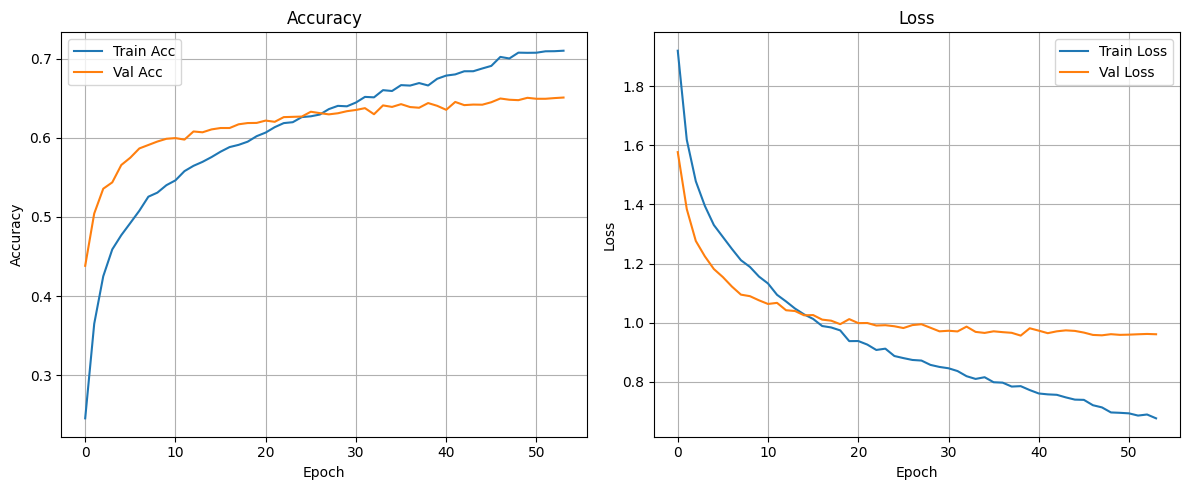


--- Step 8 Finished ---


In [22]:
# Step 8: Model Training (Swin + EffNet + EEG)
# ==============================================================================
print("\n--- Step 8: Training Model (Swin+EffNet+EEG) ---")
MODEL_WEIGHTS_FILE = "multimodal_SwinEffNetEEG_7class_best.weights.h5" # Updated filename
history = None
# Training Hyperparameters
LEARNING_RATE = 1e-4
EPOCHS = 75
BATCH_SIZE = 32 # Smaller batch size might be needed due to larger Swin features
ES_PATIENCE = 15
RLR_PATIENCE = 7

if model_built_flag and data_loaded_successfully and validation_set_available:
    print("Preparing training...")
    mc = ModelCheckpoint(filepath=MODEL_WEIGHTS_FILE, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    es = EarlyStopping(monitor='val_loss', patience=ES_PATIENCE, mode='min', restore_best_weights=True, verbose=1, start_from_epoch=10)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=RLR_PATIENCE, min_lr=1e-6, verbose=1)
    callbacks_list = [mc, es, reduce_lr]
    # Prepare Inputs/Outputs
    train_inputs = [X_train_vid, X_train_aud, X_train_eeg]
    val_inputs = [X_val_vid, X_val_aud, X_val_eeg]
    train_targets = y_train
    val_targets = y_val
    # Calculate Sample Weights
    print("Calculating sample weights...")
    sample_weights = None
    try:
        y_train_indices = np.argmax(y_train, axis=1); unique_classes = np.unique(y_train_indices)
        if len(unique_classes) == NUM_CLASSES:
             class_weights_array = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_train_indices)
             class_weights_dict = dict(enumerate(class_weights_array)); print(" Using Class Weights (mapped to sample weights):"); [print(f"  {CLASS_LABELS.get(i,'?')}: {w:.2f}") for i,w in class_weights_dict.items()]
             sample_weights = np.array([class_weights_dict[label] for label in y_train_indices], dtype=np.float32); print(f" Sample weights shape: {sample_weights.shape}")
        else: print(" WARN: Not all classes in train split. No sample weights applied.")
    except Exception as e: print(f"WARN: Sample weight calc failed: {e}.")
    # Compile and Train
    try:
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE); model_multimodal.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']); print(f" Model compiled with LR={LEARNING_RATE}.")
        print(f"\nInitiating training (Epochs: {EPOCHS}, Batch: {BATCH_SIZE})...")
        start_time = time.time()
        history = model_multimodal.fit(train_inputs, train_targets, sample_weight=sample_weights, validation_data=(val_inputs, val_targets), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
        end_time = time.time(); print(f"\n--- Training Finished --- Time: {end_time - start_time:.2f}s")
        # (Weight status reporting logic)
        weights_saved = os.path.exists(MODEL_WEIGHTS_FILE); es_restored = es.stopped_epoch > 0 and hasattr(es, 'best_weights') and es.best_weights is not None;
        if es_restored: print(f"ES restored weights from epoch {es.best_epoch + 1} (best val_loss: {es.best:.4f})")
        if weights_saved: print(f"MC saved best weights (val_acc) to '{MODEL_WEIGHTS_FILE}'.")
        elif es_restored: print("Warning: MC did not save weights, but ES restored.")
        else: print("Warning: Neither ES restored nor MC saved weights.")
    except Exception as train_e: print(f"\n--- Model Training FAILED --- Error: {train_e}"); traceback.print_exc(); history = None
else: print("Skipping Training: Model not built, data not loaded, or validation set missing.")
# --- Plot History ---
if history and hasattr(history, 'history') and history.history:
    print("\nPlotting training history...")
    # (Plotting code - same as previous)
    try: plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1); plt.plot(history.history['accuracy'], label='Train Acc'); plt.plot(history.history['val_accuracy'], label='Val Acc'); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.subplot(1, 2, 2); plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Val Loss'); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    except Exception as plot_e: print(f"Plot history failed: {plot_e}")
print("\n--- Step 8 Finished ---")



--- Step 8.5: Evaluating Model (Swin+EffNet+EEG) ---
Preparing validation data for evaluation...

Checking model weights state for evaluation...
  Evaluating using weights restored by EarlyStopping (best val_loss).

Calculating overall loss/accuracy on validation set...
  Validation Loss: 0.9566
  Validation Accuracy: 64.39%

Generating predictions & detailed reports for validation set...

--- Classification Report (Validation Set) ---
              precision    recall  f1-score   support

       angry       0.52      0.56      0.54       799
     disgust       0.69      0.55      0.61        87
        fear       0.57      0.45      0.50       820
       happy       0.82      0.83      0.83      1443
         sad       0.50      0.51      0.50       966
    surprise       0.75      0.82      0.79       634
     neutral       0.61      0.62      0.61       993

    accuracy                           0.64      5742
   macro avg       0.64      0.62      0.63      5742
weighted avg     

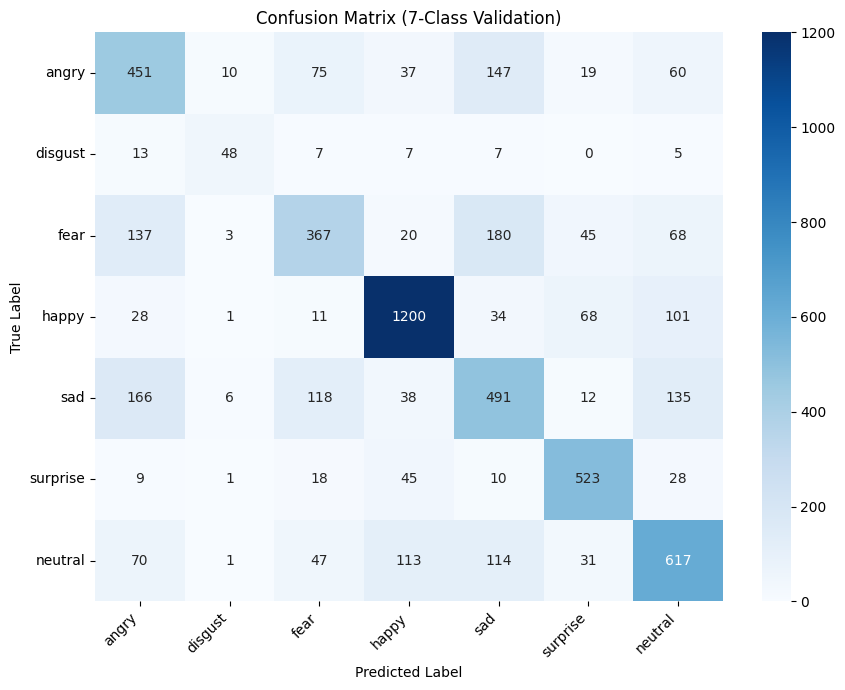

Confusion matrix plot displayed.

--- Simple Misclassification Analysis ---
  Most frequent misclassification: True 'fear' predicted as 'sad' (180 times).
  Potential Reasons: Visual/acoustic similarity, dataset ambiguity/imbalance, EEG heuristic noise.

--- Step 8.5 Finished ---


In [24]:
# ==============================================================================
# Step 8.5: Evaluate Trained Model (Swin + EffNet + EEG)
# ==============================================================================
print("\n--- Step 8.5: Evaluating Model (Swin+EffNet+EEG) ---")

# --- Prerequisite Checks ---
# Ensure model was built, data loaded, and validation set created
if 'model_built_flag' not in globals(): model_built_flag = False
if 'data_loaded_successfully' not in globals(): data_loaded_successfully = False
if 'validation_set_available' not in globals(): validation_set_available = False

if model_built_flag and data_loaded_successfully and validation_set_available:
    print("Preparing validation data for evaluation...")
    # Validation inputs (list for multi-input model)
    val_inputs = [X_val_vid, X_val_aud, X_val_eeg]
    # Ground truth labels (categorical and integer versions)
    val_true_cat = y_val # Categorical (one-hot) for evaluate function
    val_true_int = np.argmax(y_val, axis=1) # Integer labels for metrics/CM

    try:
        # --- 1. Load Best Weights ---
        print("\nChecking model weights state for evaluation...")
        # Determine which weights are currently loaded (ES restored or best saved by MC)
        weights_loaded_success = False
        es_restored = 'es' in globals() and hasattr(es, 'stopped_epoch') and es.stopped_epoch > 0 and hasattr(es, 'best_weights') and es.best_weights is not None

        if es_restored:
            print("  Evaluating using weights restored by EarlyStopping (best val_loss).")
            weights_loaded_success = True # Weights are already in the model instance
        elif os.path.exists(MODEL_WEIGHTS_FILE): # Check if best val_accuracy weights were saved
             try:
                 print(f"  Loading best weights saved by ModelCheckpoint from: {MODEL_WEIGHTS_FILE}")
                 model_multimodal.load_weights(MODEL_WEIGHTS_FILE) # Load the saved weights
                 print("  Successfully loaded best weights (best val_accuracy).")
                 weights_loaded_success = True
             except Exception as e:
                 print(f"  [WARNING] Failed to load weights from {MODEL_WEIGHTS_FILE}: {e}")
                 print("            Evaluating with model's current state (could be last epoch if ES didn't restore).")
                 # Proceed, but acknowledge weights might not be optimal
        else:
             # This case means training happened, ES didn't restore, and MC didn't save.
             print("  [WARNING] No weights file found and EarlyStopping did not restore weights.")
             print("            Evaluating with model's state at the end of training (last epoch).")
             # Proceed, but acknowledge weights might not be optimal

        # --- 2. Evaluate Overall Metrics ---
        print("\nCalculating overall loss/accuracy on validation set...")
        # Use model.evaluate with the categorical labels
        eval_results = model_multimodal.evaluate(
            val_inputs,
            val_true_cat,
            batch_size=BATCH_SIZE, # Use BATCH_SIZE defined in Step 8
            verbose=0 # Suppress evaluate progress bar
        )
        print(f"  Validation Loss: {eval_results[0]:.4f}")
        print(f"  Validation Accuracy: {eval_results[1] * 100:.2f}%")

        # --- 3. Generate Predictions & Detailed Reports ---
        print("\nGenerating predictions & detailed reports for validation set...")
        # Use model.predict to get class probabilities
        preds_proba = model_multimodal.predict(
            val_inputs,
            batch_size=BATCH_SIZE, # Use consistent batch size
            verbose=0 # Suppress predict progress bar
        )
        # Get predicted class index (highest probability)
        y_pred_classes = np.argmax(preds_proba, axis=1)

        # Define target names and labels for reports
        target_names = [CLASS_LABELS.get(i, f"Class_{i}") for i in range(NUM_CLASSES)]
        report_labels = np.arange(NUM_CLASSES) # Ensure all classes 0..N-1 are included

        # --- Classification Report ---
        print("\n--- Classification Report (Validation Set) ---")
        try:
            report = classification_report(
                val_true_int,       # Use integer ground truth labels
                y_pred_classes,     # Use integer predicted labels
                labels=report_labels,      # Explicitly define all possible labels
                target_names=target_names,
                zero_division=0        # Avoid warnings for classes with no support
            )
            print(report)
        except Exception as e:
            print(f"Error generating classification report: {e}")

        # --- Confusion Matrix ---
        print("\n--- Confusion Matrix (Validation Set) ---")
        try:
            cm = confusion_matrix(
                val_true_int,       # Use integer ground truth labels
                y_pred_classes,     # Use integer predicted labels
                labels=report_labels # Ensure matrix includes all classes 0..N-1
            )
            print("True Labels (Rows) vs Predicted Labels (Columns):\n")
            # Print formatted matrix if small enough, otherwise just the array
            if NUM_CLASSES <= 10:
                # Pretty print using pandas DataFrame for better alignment (optional)
                try:
                    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
                    print(cm_df)
                except: # Fallback if pandas fails
                    print(cm)
            else:
                 print(cm) # Print raw array for large number of classes

            # --- Plot Confusion Matrix ---
            print("\nPlotting Confusion Matrix...")
            plt.figure(figsize=(9, 7)) # Adjust size as needed
            sns.heatmap(
                cm,
                annot=True,        # Show counts in cells
                fmt='d',           # Format annotations as integers
                cmap='Blues',      # Color scheme
                xticklabels=target_names,
                yticklabels=target_names,
                cbar=True          # Show color bar
            )
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix ({NUM_CLASSES}-Class Validation)')
            plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
            plt.yticks(rotation=0)
            plt.tight_layout()     # Adjust layout to prevent overlap
            plt.show()
            print("Confusion matrix plot displayed.")

        except Exception as e:
            print(f"Error generating/plotting confusion matrix: {e}")

        # --- Basic Misclassification Analysis (Example) ---
        print("\n--- Simple Misclassification Analysis ---")
        if 'cm' in locals() and isinstance(cm, np.ndarray) and cm.shape == (NUM_CLASSES, NUM_CLASSES):
            cm_copy = cm.copy() # Work on a copy
            np.fill_diagonal(cm_copy, 0) # Zero out diagonal to find max off-diagonal
            try:
                max_conf_idx = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)
                max_conf_val = cm_copy[max_conf_idx]
                if max_conf_val > 0:
                    true_label_idx, pred_label_idx = max_conf_idx
                    true_label_name = CLASS_LABELS.get(true_label_idx, '?')
                    pred_label_name = CLASS_LABELS.get(pred_label_idx, '?')
                    print(f"  Most frequent misclassification: True '{true_label_name}' predicted as '{pred_label_name}' ({max_conf_val} times).")
                    # Add brief potential reasons relevant to 7 classes
                    print(f"  Potential Reasons: Visual/acoustic similarity, dataset ambiguity/imbalance, EEG heuristic noise.")
                else: print("  No significant off-diagonal misclassifications found.")
            except Exception as analysis_err: print(f" Error during misclassification analysis: {analysis_err}")
        else: print("  Could not perform misclassification analysis (CM unavailable or invalid).")

    except Exception as e:
        print(f"\nAn error occurred during model evaluation: {e}")
        traceback.print_exc()

# --- Handle cases where evaluation cannot proceed ---
elif not model_built_flag:
    print("Skipping evaluation: Model was not built successfully.")
elif not data_loaded_successfully:
    print("Skipping evaluation: Data was not loaded successfully.")
elif not validation_set_available:
    print("Skipping evaluation: Validation data is not available.")
else:
    print("Skipping evaluation: Unknown prerequisite issue.")

print("\n--- Step 8.5 Finished ---")

In [25]:
# Step 9: Remedy Generation Function (7 Classes)
# ==============================================================================
print("\n--- Step 9: Defining Remedy Generation Function (7 Classes) ---")
# (Use the 7-class remedy function definition from previous response)
def generate_remedy(emotion_label):
    global text_generator; emotion_label_lower = emotion_label.lower();
    if emotion_label_lower == "happiness": return "Embrace the positivity! Share the joy?"
    if emotion_label_lower == "neutral": return "Feeling balanced. A good time for mindfulness."
    if emotion_label_lower == "surprise": return "Take a moment to process the surprise."
    prompts = { "anger": "I feel angry. Suggest one quick technique to cool down:", "disgust": "I feel disgusted. Suggest a simple way to shift my focus:", "fear": "I feel fear. Suggest one simple grounding technique:", "sadness": "I feel sad. Suggest one small, comforting action I can take now:", }
    prompt = prompts.get(emotion_label_lower)
    if not prompt: return f"Feeling {emotion_label}. Acknowledge this feeling."
    if not HUGGINGFACE_AVAILABLE or text_generator is None: return f"Try taking deep breaths to manage feeling {emotion_label}."
    print(f"  Generating remedy for '{emotion_label}'...");
    try:
        response = text_generator(prompt, max_new_tokens=40, num_return_sequences=1, pad_token_id=text_generator.tokenizer.eos_token_id, eos_token_id=text_generator.tokenizer.eos_token_id, num_beams=3, early_stopping=True, truncation=True)
        generated_text = response[0]['generated_text']; suggestion_text = generated_text
        if generated_text.startswith(prompt): suggestion_text = generated_text[len(prompt):].strip()
        suggestion_text = re.sub(r'\s+', ' ', suggestion_text).strip().replace('"', ''); first_suggestion = suggestion_text.split('.')[0]
        if len(first_suggestion) < 5: first_suggestion = suggestion_text.split('\n')[0]
        max_len = 150; final_suggestion = first_suggestion.strip()[:max_len] + ('...' if len(first_suggestion) > max_len else '')
        return final_suggestion if final_suggestion else "Could not generate clear suggestion."
    except Exception as e: print(f"Remedy Gen Error: {e}"); return "Suggestion generation failed."
print("Remedy generation function (7 classes) defined.")


--- Step 9: Defining Remedy Generation Function (7 Classes) ---
Remedy generation function (7 classes) defined.


In [45]:
# ==============================================================================
# Step 10: Live Capture & Prediction (Swin + EffNet + EEG - Corrected)
# ==============================================================================
print("\n--- Step 10: Defining Live Capture & Prediction Functions (Swin+EffNet+EEG - Corrected) ---")

# Ensure necessary imports for this step (some might be redundant if globally imported)
import numpy as np
import cv2
import time
import io
import random
import os
import pandas as pd
import librosa # Keep if used in audio feature extraction
import soundfile as sf # Keep if used in audio feature extraction
from PIL import Image as PILImage
from base64 import b64decode

# Ensure Colab-specific imports are available if needed
if IN_COLAB:
    from IPython.display import Javascript, display, Image as IPImage
    from google.colab import output
else: # Define dummies if not in Colab
    def display(*args, **kwargs): pass
    def Javascript(*args, **kwargs): pass
    def files(*args, **kwargs): return type('obj', (object,), {'upload': lambda: print("File upload only available in Colab.")})()
    def output(*args, **kwargs): return type('obj', (object,), {'eval_js': lambda x: None, 'register_callback': lambda x,y: None})()
    IPImage = lambda *args, **kwargs: None
    b64decode = lambda x: b""


# --- I. JavaScript Generation Functions ---

def js_capture_photo(quality=0.8):
    """Generates JS code to capture a webcam photo in Colab."""
    js_code = f'''
    async function capturePhoto(quality) {{
      const div = document.createElement('div'); const captureButton = document.createElement('button');
      captureButton.textContent = 'Capture Video Frame'; div.appendChild(captureButton);
      const video = document.createElement('video'); video.style.display = 'block';
      let stream; // Declare stream variable
      try {{
          stream = await navigator.mediaDevices.getUserMedia({{ video: true }});
      }} catch (err) {{
          console.error("Error accessing webcam:", err);
          div.innerHTML = "Error accessing webcam. Please grant permission.";
          return null; // Return null on error
      }}
      document.body.appendChild(div); div.appendChild(video);
      video.srcObject = stream; await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true); // Adjust frame height
      await new Promise((resolve) => captureButton.onclick = resolve); // Wait for click
      const canvas = document.createElement('canvas'); canvas.width = video.videoWidth; canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      // Stop stream tracks BEFORE removing element
      stream.getVideoTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }}
    '''
    if IN_COLAB:
        display(Javascript(js_code))
        data=output.eval_js(f'capturePhoto({quality})')
        return data
    else:
        print("Live capture only available in Colab.");
        return None

def js_record_audio(duration_sec=AUDIO_RECORD_DURATION_SEC, sample_rate=AUDIO_SAMPLE_RATE):
    """Generates JS code to record audio in Colab and send data via callback."""
    if not IN_COLAB: print("Live audio only available in Colab."); return None
    register_audio_callback() # Ensure callback is registered
    # JavaScript code using AudioContext for WAV encoding
    js_code=f"""
    async function recordAudioAndCallback(duration, targetSampleRate) {{
        const div = document.createElement('div'); const startButton = document.createElement('button');
        startButton.textContent = 'Start Recording ({duration_sec}s)'; div.appendChild(startButton); document.body.appendChild(div);
        await new Promise(resolve => startButton.onclick = resolve); startButton.textContent = 'Recording...'; startButton.disabled = true;
        google.colab.kernel.invokeFunction('notebook.audio_callback', ['RECORDING_STARTED'], {{}}); // Notify Python
        let stream; // Declare stream variable
        try {{
            stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
            const audioContext = new (window.AudioContext || window.webkitAudioContext)({{ sampleRate: targetSampleRate }});
            const source = audioContext.createMediaStreamSource(stream);
            const processor = audioContext.createScriptProcessor(4096, 1, 1); // Buffer size, input/output channels
            let audioData = []; processor.onaudioprocess = (e) => {{ audioData.push(new Float32Array(e.inputBuffer.getChannelData(0))); }}; // Store chunk
            source.connect(processor); processor.connect(audioContext.destination); // Necessary to start processing
            await new Promise(resolve => setTimeout(resolve, duration * 1000)); // Record duration
            processor.disconnect(); source.disconnect(); stream.getAudioTracks().forEach(track => track.stop()); audioContext.close(); div.remove(); // Stop & cleanup
            // Combine PCM chunks
            const totalLength = audioData.reduce((sum, buf) => sum + buf.length, 0); const combinedPCM = new Float32Array(totalLength);
            let offset = 0; for (const buf of audioData) {{ combinedPCM.set(buf, offset); offset += buf.length; }}
            // Encode PCM to WAV blob
            const wavBuffer = encodeWAV(combinedPCM, targetSampleRate); const blob = new Blob([wavBuffer], {{ type: 'audio/wav' }});
            // Convert Blob to Base64 Data URL and send to Python
            const reader = new FileReader(); reader.onloadend = () => {{ google.colab.kernel.invokeFunction('notebook.audio_callback', [reader.result], {{}}); }}; reader.readAsDataURL(blob);
        }} catch (err) {{
             console.error("Audio recording/processing failed:", err);
             google.colab.kernel.invokeFunction('notebook.audio_callback', ['RECORDING_ERROR:' + err.message], {{}});
             if(stream) {{ stream.getAudioTracks().forEach(track => track.stop()); }} // Stop stream on error too
             if(div) div.remove();
        }}
    }}
    // Helper functions for WAV encoding (included within the JS string)
    function encodeWAV(smp,sr){{ const buf=new ArrayBuffer(44+smp.length*2);const view=new DataView(buf);writeString(view,0,'RIFF');view.setUint32(4,36+smp.length*2,true);writeString(view,8,'WAVE');writeString(view,12,'fmt ');view.setUint32(16,16,true);view.setUint16(20,1,true);view.setUint16(22,1,true);view.setUint32(24,sr,true);view.setUint32(28,sr*2,true);view.setUint16(32,2,true);view.setUint16(34,16,true);writeString(view,36,'data');view.setUint32(40,smp.length*2,true);floatTo16BitPCM(view,44,smp);return buf;}}
    function writeString(view,offset,string){{ for(let i=0;i<string.length;i++){{view.setUint8(offset+i,string.charCodeAt(i));}} }}
    function floatTo16BitPCM(output,offset,input){{ for(let i=0;i<input.length;i++,offset+=2){{const s=Math.max(-1,Math.min(1,input[i]));output.setInt16(offset,s<0?s*0x8000:s*0x7FFF,true);}} }}
    """ # <<< Closing triple quotes >>>
    js = Javascript(js_code); display(js); print(f"Click 'Start Recording ({duration_sec}s)' button above...")
    output.eval_js(f'recordAudioAndCallback({duration_sec},{sample_rate})') # Execute the JS

# --- II. Python Callback & Registration ---

colab_audio_data_buffer = None # Global variable to hold audio data from JS

def _audio_callback_colab(data_url_or_status: str):
    """Internal callback function invoked by Colab kernel from JS audio recorder."""
    global colab_audio_data_buffer
    if isinstance(data_url_or_status, str):
        if data_url_or_status.startswith("data:audio/wav;base64,"):
            colab_audio_data_buffer = data_url_or_status;
            # print("  Audio data received.") # Can be verbose
        elif data_url_or_status == "RECORDING_STARTED":
            print("  Audio recording started.")
        elif data_url_or_status.startswith("RECORDING_ERROR"):
            print(f"  Audio Error from JS: {data_url_or_status}");
            colab_audio_data_buffer = "ERROR" # Signal error state
        else:
            colab_audio_data_buffer = None # Ignore other messages
    else:
        colab_audio_data_buffer = None

def register_audio_callback():
    """Registers the Python callback for audio data if in Colab."""
    if IN_COLAB:
        try:
            from google.colab import output # Ensure import
            output.register_callback('notebook.audio_callback', _audio_callback_colab)
        except Exception: pass # Ignore if already registered

# Register callback once after function definition
if IN_COLAB: register_audio_callback()

# --- III. Python Capture Wrapper Functions ---

def capture_video_frame_colab() -> np.ndarray | None:
    """Initiates video capture in Colab and returns an OpenCV frame (BGR)."""
    if not IN_COLAB: print("Video capture requires Colab."); return None
    try:
        print("Waiting for user to click 'Capture Video Frame'...") # Corrected string literal
        data_url = js_capture_photo();
        if not data_url: print("ERROR: Video capture failed or cancelled."); return None
        # Decode Base64
        header, encoded = data_url.split(",", 1); binary_data = b64decode(encoded)
        # Convert to OpenCV format
        image_pil = PILImage.open(io.BytesIO(binary_data)); frame_bgr = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        print("Video frame captured."); return frame_bgr
    except Exception as e: print(f"ERROR during video capture: {e}"); return None

def capture_audio_data_colab(duration_sec: int = AUDIO_RECORD_DURATION_SEC) -> io.BytesIO | None:
    """Initiates audio recording in Colab and returns a BytesIO buffer."""
    if not IN_COLAB: print("Audio capture requires Colab."); return None
    global colab_audio_data_buffer; colab_audio_data_buffer = None; # Reset buffer
    try:
        js_record_audio(duration_sec); timeout = duration_sec + 25 # Timeout in seconds
        print(f"Waiting up to ~{timeout}s for audio data after clicking start...")
        start_time = time.time()
        while colab_audio_data_buffer is None and (time.time() - start_time) < timeout: time.sleep(0.5) # Wait for callback
        # Process result
        if isinstance(colab_audio_data_buffer, str) and colab_audio_data_buffer.startswith("data:audio/wav;base64,"):
            print("Audio captured."); header, encoded = colab_audio_data_buffer.split(",", 1); binary_data = b64decode(encoded); return io.BytesIO(binary_data)
        else: print(f"ERROR: Audio capture failed, timed out, or error from JS. Buffer: {colab_audio_data_buffer}"); return None
    except Exception as e: print(f"ERROR during audio capture initiation: {e}"); return None
    finally: colab_audio_data_buffer = None # Clear buffer

# --- IV. Utility Functions ---

def load_sample_bonn_eeg(bonn_base_path: str, category: str = 'Z') -> np.ndarray | None:
    """Loads a single random EEG signal file from a specified Bonn category."""
    # Assumes bonn_data_present is a global flag set in Step 1.6
    if 'bonn_data_present' not in globals() or not bonn_data_present: print(f"ERROR: Bonn data not present/verified."); return None
    cat_path = os.path.join(bonn_base_path, category);
    if not os.path.isdir(cat_path): print(f"ERROR: EEG Category dir missing: {cat_path}"); return None
    try:
        files = glob.glob(os.path.join(cat_path,"*.txt")) + glob.glob(os.path.join(cat_path,"*.TXT")) # Case-insensitive
        if not files: print(f"ERROR: No EEG .txt/.TXT files found in {cat_path}"); return None
        f = random.choice(files); sig = pd.read_csv(f, header=None).values.flatten();
        if len(sig) == EEG_SIGNAL_LENGTH: print(f"Loaded sample Bonn EEG: {os.path.basename(f)}"); return sig
        else: print(f"ERROR: Bonn EEG wrong length: {len(sig)} in {os.path.basename(f)}"); return None
    except Exception as e: print(f"Error loading Bonn EEG sample: {e}"); return None

def draw_text(img: np.ndarray, text: str, org: tuple, font_scale: float = 0.5,
              color: tuple = (255, 255, 255), thickness: int = 1, line_spacing: float = 1.3) -> int:
    """Draws multi-line text with a black background onto an image."""
    font = cv2.FONT_HERSHEY_SIMPLEX; lines = text.split('\n');
    if not lines or not any(line.strip() for line in lines): return org[1] # Handle empty text
    # Estimate line height based on the first non-empty line
    first_line_idx = next((i for i, line in enumerate(lines) if line.strip()), 0)
    (tw, th), baseline = cv2.getTextSize(lines[first_line_idx], font, font_scale, thickness)
    if th == 0: th = int(font_scale * 20) # Estimate height if getTextSize fails

    y = org[1]; # Starting y position for baseline of first line
    line_count_drawn = 0
    for i, line in enumerate(lines):
        line = line.strip() # Remove leading/trailing whitespace for positioning
        if not line: continue # Skip truly empty lines

        (lw, lh), line_bl = cv2.getTextSize(line, font, font_scale, thickness)
        line_y_baseline = y + line_count_drawn * int(th * line_spacing) # Position baseline
        # Background rectangle coordinates (with padding)
        bg_x1 = org[0] - 2; bg_y1 = line_y_baseline - th - baseline + 1 - 2;
        bg_x2 = org[0] + lw + 2; bg_y2 = line_y_baseline + baseline + 2;
        cv2.rectangle(img, (bg_x1, bg_y1), (bg_x2, bg_y2), (0, 0, 0), -1) # Black background
        cv2.putText(img, line, (org[0], line_y_baseline), font, font_scale, color, thickness, cv2.LINE_AA) # Draw text
        line_count_drawn += 1

    # Return the approximate y-coordinate below the last line drawn
    return y + line_count_drawn * int(th * line_spacing)


# --- V. Load Face Detection Cascade (Corrected Structure) ---
print("\nLoading Haar Cascade for face detection...")
face_cascade = None
haar_cascade_present = False
haar_path_to_load = None # Path determined to be loaded or downloaded to
CASCADE_FILENAME = "haarcascade_frontalface_default.xml" # Define filename

try: # Outer try for the whole loading process
    # 1. Check current directory
    if os.path.exists(CASCADE_FILENAME):
        print(f"  Found cascade file in current directory.")
        haar_path_to_load = CASCADE_FILENAME
        haar_cascade_present = True

    # 2. If not found, try standard OpenCV data directory
    if not haar_cascade_present:
        try: # Nested try specifically for finding OpenCV path
            cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
            haar_path_cv2 = os.path.join(cv2_base_dir, 'data', CASCADE_FILENAME)
            if os.path.exists(haar_path_cv2):
                print(f"  Found cascade file in OpenCV data directory: {haar_path_cv2}")
                haar_path_to_load = haar_path_cv2
                haar_cascade_present = True
        except Exception:
            pass # Ignore errors finding OpenCV path, proceed to download check

    # Set path for potential download if still not found after checks 1 & 2
    if not haar_cascade_present:
        haar_path_to_load = CASCADE_FILENAME # Default download path to current dir

    # 3. Download if not found and in Colab
    if not haar_cascade_present and IN_COLAB:
        print(f"  Attempting to download cascade file to {haar_path_to_load}...")
        download_url = f"https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/{CASCADE_FILENAME}"
        download_cmd = f"wget -q -O {haar_path_to_load} {download_url}"
        exit_code_wget = os.system(download_cmd)
        if exit_code_wget == 0 and os.path.exists(haar_path_to_load):
            print("  Download successful.")
            haar_cascade_present = True
        else:
            print(f"  [ERROR] Failed to download Haar cascade (wget exit code: {exit_code_wget}).")
            haar_cascade_present = False
            if os.path.exists(haar_path_to_load): os.remove(haar_path_to_load) # Clean up failed download

    # 4. Load the cascade classifier if a path was successfully determined
    if haar_cascade_present and haar_path_to_load:
        print(f"  Loading cascade from: {haar_path_to_load}")
        face_cascade = cv2.CascadeClassifier(haar_path_to_load)
        if face_cascade.empty():
             print(f"  [ERROR] Loaded Haar Cascade from {haar_path_to_load} is empty.")
             face_cascade = None # Ensure None if empty
        else:
             print(f"  [OK] Haar Cascade loaded successfully.")
    elif not haar_cascade_present:
         print(f"  [ERROR] Haar Cascade file '{CASCADE_FILENAME}' could not be found or downloaded.")

# Outer except block catches broader errors during the whole process
except Exception as e:
    print(f"[ERROR] during Haar Cascade loading logic: {e}")
    face_cascade = None

# Final check
if face_cascade is None:
    print("\n[WARN] Face cascade loading failed or file is empty. Face detection/visualization disabled.")


# --- VI. Main Live Prediction Runner Function (Corrected Display Logic) ---
def run_live_prediction_colab_visual(model_obj, bonn_path, face_cascade_obj):
    """
    Runs live prediction using Swin (Video), EffNet (Audio), and sample Bonn EEG features.
    Corrected the local display 'else' block and remedy text wrapping/drawing.

    Args:
        model_obj (tf.keras.Model): The trained 3-input multimodal model.
        bonn_path (str): Path to the Bonn EEG dataset for loading samples.
        face_cascade_obj (cv2.CascadeClassifier | None): Loaded Haar cascade object.
    """
    print("\n" + "▶️" * 3 + " Live Prediction Cycle (7 Classes - Swin+EffNet+EEG) " + "▶️" * 3)

    # --- 1. Prerequisite Checks & Initialization ---
    print("Checking prerequisites...")
    if not IN_COLAB: print("❌ ERROR: Live capture requires Colab."); return
    if model_obj is None: print("❌ ERROR: Multimodal model not available."); return
    if face_cascade_obj is None: print("❌ WARN: Face cascade not loaded. Face detection skipped.");
    # Use global bonn_data_present flag
    if 'bonn_data_present' not in globals() or not bonn_data_present: print("❌ WARN: Bonn data not verified. Sample EEG may fail.");

    vid_feat = ZERO_VIDEO_FEAT; aud_feat = ZERO_AUDIO_FEAT; eeg_feat = ZERO_EEG_FEAT;
    pred_emo_display = "Initializing..."; conf_display = 0.0; remedy = "N/A"; face_coords = None;

    # --- 2. Load Sample EEG Context ---
    print("\nLoading static sample Bonn EEG context ('Z')...")
    eeg_raw = load_sample_bonn_eeg(bonn_path, category='Z'); temp_eeg_feat = None
    if eeg_raw is not None: temp_eeg_feat = process_bonn_eeg_signal(eeg_raw)
    if temp_eeg_feat is None or not np.any(temp_eeg_feat): print("  WARN: Using ZERO EEG features."); eeg_feat = ZERO_EEG_FEAT
    else: eeg_feat = temp_eeg_feat; print("  ✅ Static Bonn EEG features processed.")
    eeg_in = np.expand_dims(eeg_feat, axis=0).astype(np.float32)

    # --- 3. Capture Live Video & Audio ---
    print("\nInitiating video frame capture..."); frame_bgr = capture_video_frame_colab();
    if frame_bgr is None: print("❌ Abort: Video capture failed."); return
    disp_frame = frame_bgr.copy(); print("  ✅ Video frame captured.")
    print("Initiating audio snippet capture..."); audio_buffer = capture_audio_data_colab();
    if audio_buffer is None: print("  WARN: Audio capture failed, using zeros."); audio_feat = ZERO_AUDIO_FEAT
    else:
        print("  Processing audio (EffNet Feats)..."); temp_audio_feat = extract_audio_features_effnet(audio_buffer, augment=False);
        if temp_audio_feat is not None and np.any(temp_audio_feat): audio_feat = temp_audio_feat; print("  ✅ Live audio features processed.")
        else: print("  WARN: Audio feature extraction failed."); audio_feat = ZERO_AUDIO_FEAT
    aud_in = np.expand_dims(audio_feat, 0).astype(np.float32)

    # --- 4. Face Detection & Video Feature Extraction ---
    pred_emo_display = "No face" # Reset status
    if face_cascade_obj is not None:
        print("\nDetecting face..."); gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY);
        faces = face_cascade_obj.detectMultiScale(gray, 1.1, 4, minSize=(40, 40)); print(f"  Detected {len(faces)} face(s).")
        if len(faces) > 0:
            faces = sorted(faces, key=lambda f: f[2]*f[3], reverse=True); x,y,w,h = faces[0]; face_coords=(x,y,w,h)
            cv2.rectangle(disp_frame, (x,y), (x+w,y+h), (0,255,0), 2) # Draw box
            face_roi_bgr = frame_bgr[y:y+h, x:x+w]
            if face_roi_bgr.size > 0:
                print("  Extracting video features (Swin)...")
                temp_vid_feat = extract_video_features_swin(face_roi_bgr, augment=False) # Use Swin extractor
                if temp_vid_feat is not None and np.any(temp_vid_feat): vid_feat = temp_vid_feat; pred_emo_display = "Processing..."; print("  ✅ Video features extracted.")
                else: print("  WARN: Video feature extraction failed."); pred_emo_display="Feature Error"
            else: print("  WARN: ROI empty."); pred_emo_display="ROI Error"
        else: pred_emo_display = "No face detected"
    else: print("  Skipping face detection (cascade not available)."); pred_emo_display="No Cascade"
    vid_in = np.expand_dims(vid_feat, 0).astype(np.float32) # Batch dim

    # --- 5. Multimodal Prediction ---
    if pred_emo_display == "Processing...": # Predict only if face features were extracted
        print("Predicting emotion...")
        try:
            model_inputs = [vid_in, aud_in, eeg_in] # Order: Swin, EffNet, EEG
            preds_proba = model_obj.predict(model_inputs, verbose=0)[0]
            pred_idx=np.argmax(preds_proba); conf_display=np.max(preds_proba)*100
            pred_emo_display=CLASS_LABELS.get(pred_idx,"?") # Get 7-class label name
            print(f"---> Prediction: {pred_emo_display} ({conf_display:.1f}%)")
            remedy = generate_remedy(pred_emo_display) # Generate remedy
            print(f"---> Suggestion: {remedy}")
        except Exception as e: print(f"  [ERROR] Predict/Remedy failed: {e}"); pred_emo_display="Predict Error"; remedy="N/A"
    else: print(f"Skipping prediction ({pred_emo_display})."); remedy = "N/A"

    # --- 6. Display Results ---
    print("\n--- 📊 Results Display ---")
    org=(10,30); color=(0,255,255); fs=0.6; tk=1; ls=1.3 # Text parameters

    # Draw prediction near face box (only if face detected and prediction occurred)
    if face_coords is not None and pred_emo_display not in ["No face detected", "ROI Error", "Feature Error", "Predict Error", "No Cascade", "Initializing...", "Processing..."]:
         draw_text(disp_frame, f"{pred_emo_display} ({conf_display:.0f}%)", (face_coords[0], face_coords[1]-10 if face_coords[1]>20 else face_coords[1]+face_coords[3]+15), font_scale=0.6, color=(0,255,0), thickness=2)

    # Draw overall status/info text
    info_text=f"Status: {pred_emo_display}" + (f" ({conf_display:.1f}%)" if conf_display > 0 and pred_emo_display not in ["No face detected", "ROI Error", "Feature Error", "No Cascade", "Initializing...", "Processing..."] else "")
    last_y = draw_text(disp_frame, info_text, org, fs, color, tk, ls);

    # Draw remedy suggestion
    if remedy != "N/A":
        st = "Suggestion:"
        ly_sugg_title = draw_text(disp_frame, st, (org[0], last_y + 5), fs*0.9, color, tk, ls) # Draw title

        # --- Corrected Remedy Wrapping and Drawing ---
        wrapped_remedy = ""
        max_line_len = 50 # Adjust characters per line as needed
        current_line = ""
        words = remedy.split()
        for i, word in enumerate(words):
            test_line = current_line + (" " if current_line else "") + word
            # Check rough length (simple character count)
            if len(test_line) <= max_line_len:
                current_line = test_line
            else:
                wrapped_remedy += current_line + "\n" # Add completed line
                current_line = word # Start new line
        wrapped_remedy += current_line # Add the last line

        # Draw the wrapped text starting below the title
        # Use ly_sugg_title as the starting y coordinate
        draw_text(disp_frame, wrapped_remedy, (org[0]+5, ly_sugg_title), fs*0.85, (255,255,255), 1, ls)


    # --- Display Final Image ---
    if IN_COLAB:
        # Ensure Colab display modules are available
        from IPython.display import display
        from PIL import Image as PILImage # Ensure PIL is imported
        display(PILImage.fromarray(cv2.cvtColor(disp_frame, cv2.COLOR_BGR2RGB)))
    else:
        # <<< CORRECTED INDENTATION for local display >>>
        try:
            cv2.imshow("Live Prediction (Swin+EffNet+EEG)", disp_frame)
            # waitKey(1) is crucial for imshow to refresh in a script
            key = cv2.waitKey(1) & 0xFF
            # Optional: Add logic to close window if 'q' is pressed
            # if key == ord('q'):
            #    cv2.destroyAllWindows() # Important to close windows properly
            #    print("Local display window closed by user.")
        except Exception as e:
            # Catch errors if GUI is not available
            print(f"Could not display frame locally using cv2.imshow: {e}")
            print(" (Ensure you have a GUI environment/display connected if not in Colab)")


    print("\n" + "✅" * 3 + " Live Prediction Cycle Complete " + "✅" * 3)


print("\nLive capture and prediction functions defined (Swin+EffNet+EEG - Corrected).")


--- Step 10: Defining Live Capture & Prediction Functions (Swin+EffNet+EEG - Corrected) ---

Loading Haar Cascade for face detection...
  Found cascade file in OpenCV data directory: /usr/local/lib/python3.11/dist-packages/cv2/data/haarcascade_frontalface_default.xml
  Loading cascade from: /usr/local/lib/python3.11/dist-packages/cv2/data/haarcascade_frontalface_default.xml
  [OK] Haar Cascade loaded successfully.

Live capture and prediction functions defined (Swin+EffNet+EEG - Corrected).



=============== Step 11: Running Main Execution Block (Swin+EffNet+EEG) ===============

Checking prerequisites for live prediction execution...
  - Multimodal Model Ready: True
  - Face Cascade Ready:     True
  - Bonn EEG Data OK:       True
  - Live Environment OK:    True

✅ All prerequisites met for live prediction.
Verifying model weights state...
  - Using model weights restored by EarlyStopping (best val_loss).

Initiating live prediction cycle...

▶️▶️▶️ Live Prediction Cycle (7 Classes - Swin+EffNet+EEG) ▶️▶️▶️
Checking prerequisites...

Loading static sample Bonn EEG context ('Z')...
Loaded sample Bonn EEG: Z042.txt
  ✅ Static Bonn EEG features processed.

Initiating video frame capture...
Waiting for user to click 'Capture Video Frame'...


<IPython.core.display.Javascript object>

Video frame captured.
  ✅ Video frame captured.
Initiating audio snippet capture...


<IPython.core.display.Javascript object>

Click 'Start Recording (4s)' button above...
Waiting up to ~29s for audio data after clicking start...
ERROR: Audio capture failed, timed out, or error from JS. Buffer: None
  WARN: Audio capture failed, using zeros.

Detecting face...
  Detected 1 face(s).
  Extracting video features (Swin)...
  ✅ Video features extracted.
Predicting emotion...
---> Prediction: sad (45.8%)
---> Suggestion: Feeling sad. Acknowledge this feeling.

--- 📊 Results Display ---


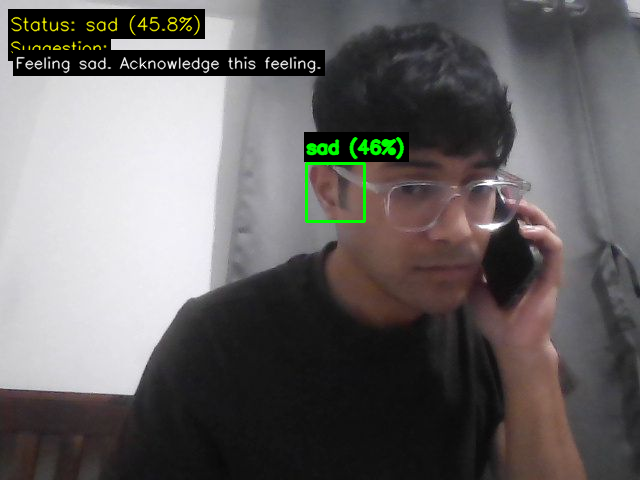


✅✅✅ Live Prediction Cycle Complete ✅✅✅

================= Script Execution Finished =================


--- Discussion & Improvement Ideas (Swin+EffNet+EEG Model) ---

1. Analyze Misclassifications:
   - Examine the 7x7 confusion matrix generated in Step 8.5.
   - Identify pairs of emotions with high confusion rates (e.g., Fear/Surprise, Anger/Disgust, Sad/Neutral).
   - Potential Reasons: Visual similarities (Swin features), acoustic similarities (EffNet features), heuristic EEG mapping noise, FER dataset ambiguity/imbalance.
   - Action: Inspect misclassified examples. Consider fine-tuning base models, using different features, or advanced fusion.

2. Hyperparameter Tuning:
   - Optimize: Learning Rate, Batch Size, Dropout Rates (branch-specific and fused), Dense Layer Units, Optimizer (AdamW?), L2 Regularization.
   - Tools: KerasTuner, Optuna.

3. Feature Fusion Techniques:
   - Current: Simple Concatenation.
   - Explore: Attention mechanisms (self-attention within branches, cros

In [48]:
# ==============================================================================
# Step 11: Main Execution Block (Run Live Prediction)
# ==============================================================================
print("\n" + "="*15 + " Step 11: Running Main Execution Block (Swin+EffNet+EEG) " + "="*15)

# This block executes the live prediction cycle if all prerequisites are met.
if __name__ == "__main__":
    print("\nChecking prerequisites for live prediction execution...")

    # --- Verify Necessary Components are Ready ---
    # 1. Model: Was the multimodal model built successfully?
    model_ready = 'model_multimodal' in globals() and model_multimodal is not None and model_built_flag
    # 2. Cascade: Was the Haar Cascade loaded for face detection?
    cascade_ready = 'face_cascade' in globals() and face_cascade is not None
    # 3. Bonn Data: Was Bonn data verified for loading sample EEG?
    bonn_ready = 'bonn_data_present' in globals() and bonn_data_present
    # 4. Environment: Are we in Colab (required for capture functions)?
    live_env_ok = IN_COLAB

    print(f"  - Multimodal Model Ready: {model_ready}")
    print(f"  - Face Cascade Ready:     {cascade_ready}")
    print(f"  - Bonn EEG Data OK:       {bonn_ready}")
    print(f"  - Live Environment OK:    {live_env_ok}")

    # --- Execute Live Prediction if All Prerequisites Met ---
    if model_ready and bonn_ready and cascade_ready and live_env_ok:
        print("\n✅ All prerequisites met for live prediction.")

        # --- Verify Model Weights ---
        # Check if training occurred and if weights were restored by ES or saved by MC
        print("Verifying model weights state...")
        weights_available = False
        training_completed = 'history' in globals() and history is not None # Check if history object exists from Step 8
        es_restored = training_completed and 'es' in globals() and hasattr(es, 'stopped_epoch') and es.stopped_epoch > 0 and hasattr(es, 'best_weights') and es.best_weights is not None

        if es_restored:
            print("  - Using model weights restored by EarlyStopping (best val_loss).")
            weights_available = True
        elif os.path.exists(MODEL_WEIGHTS_FILE): # Check if MC saved the best weights file
            try:
                print(f"  - Attempting to load best weights from: {MODEL_WEIGHTS_FILE}")
                # Load the weights into the existing model instance
                model_multimodal.load_weights(MODEL_WEIGHTS_FILE)
                print("  - Best weights (best val_accuracy) loaded successfully from file.")
                weights_available = True
            except Exception as e:
                print(f"  - [WARNING] Error loading weights from file: {e}.")
                print("    Proceeding with current model state (might be last epoch or initial if ES didn't restore).")
                weights_available = True # Allow proceeding, but warn
        elif training_completed:
             # Training happened, ES didn't restore, MC didn't save
             print(f"  - [WARNING] Training occurred but no weights file found ('{MODEL_WEIGHTS_FILE}') and ES did not restore.")
             print("    Using model weights from the final epoch of training.")
             weights_available = True # Allow proceeding with final epoch weights
        else: # No training and no file
            print("  - [WARNING] Model is likely untrained (no training history found, no weights file).")
            print("    Predictions will be based on initial random weights.")
            weights_available = True # Allow proceeding with initial weights

        # --- Run Prediction Cycle ---
        if weights_available:
             print("\nInitiating live prediction cycle...")
             try:
                 # Call the main prediction function defined in Step 10
                 run_live_prediction_colab_visual(
                     model_obj=model_multimodal,      # Pass the trained multimodal model
                     bonn_path=COLAB_BONN_PATH,       # Pass path to Bonn dataset for sample EEG
                     face_cascade_obj=face_cascade    # Pass the loaded Haar cascade
                 )
             except Exception as main_e:
                 # Catch unexpected errors during the live run
                 print(f"\n--- 💥 UNEXPECTED ERROR during live prediction execution ---")
                 print(f"{main_e}")
                 traceback.print_exc()
        else:
             # This case should be rare if the logic above is correct
             print("\nSkipping live prediction due to issues loading usable model weights.")

    # --- Explain if Prerequisites Failed ---
    elif not live_env_ok:
         print("\nSkipping live prediction: Not running in Google Colab environment.")
    else:
        print("\n❌ ERROR: Not all prerequisites met for running live prediction.")
        if not model_ready: print("  - Issue: Multimodal model ('model_multimodal') is not built or ready.")
        if not cascade_ready: print("  - Issue: Face detection cascade ('face_cascade') failed to load.")
        if not bonn_ready: print("  - Issue: Bonn EEG data ('bonn_data_present' flag is False) seems missing or path is invalid.")
        print("Please review previous steps (Dataset Download/Setup, Model Building, Cascade Loading).")

print("\n" + "="*17 + " Script Execution Finished " + "="*17)

# ============================================================
# --- Discussion Points & Further Improvements ---
# ============================================================
print("\n\n" + "="*20 + "\n--- Discussion & Improvement Ideas (Swin+EffNet+EEG Model) ---\n" + "="*20)
print("\n1. Analyze Misclassifications:")
print("   - Examine the 7x7 confusion matrix generated in Step 8.5.")
print("   - Identify pairs of emotions with high confusion rates (e.g., Fear/Surprise, Anger/Disgust, Sad/Neutral).")
print("   - Potential Reasons: Visual similarities (Swin features), acoustic similarities (EffNet features), heuristic EEG mapping noise, FER dataset ambiguity/imbalance.")
print("   - Action: Inspect misclassified examples. Consider fine-tuning base models, using different features, or advanced fusion.")
print("\n2. Hyperparameter Tuning:")
print("   - Optimize: Learning Rate, Batch Size, Dropout Rates (branch-specific and fused), Dense Layer Units, Optimizer (AdamW?), L2 Regularization.")
print("   - Tools: KerasTuner, Optuna.")
print("\n3. Feature Fusion Techniques:")
print("   - Current: Simple Concatenation.")
print("   - Explore: Attention mechanisms (self-attention within branches, cross-modal attention between Swin/EffNet), Bilinear Pooling, Gated Multimodal Units.")
print("\n4. Modality Contribution (Ablation Study):")
print("   - Train models with fewer modalities:")
print("     - Swin + EffNet")
print("     - Swin + EEG")
print("     - EffNet + EEG")
print("   - Compare performance against the full Swin+EffNet+EEG model to quantify each modality's impact (especially the heuristic EEG).")
print("\n5. Base Model Fine-tuning:")
print("   - Unfreeze some layers of Swin and/or EfficientNetB0 during training (requires careful LR adjustment, potentially much lower).")
print("   - Could adapt them better to the specific emotion recognition task compared to using only ImageNet features.")
print("\n6. Data Augmentation & Quality:")
print("   - Video: Explore Albumentations for more diverse transformations.")
print("   - Audio: Add background noise, reverberation, etc.")
print("   - Address Imbalance: Use techniques like SMOTE (carefully) or weighted loss functions beyond simple class weighting.")